# DL project for Domain Adaptation

In this notebook we will try to solve a task on domain adaptation

## Initial setup

Here we import libraries and set up the dataset

In [1]:
from os import makedirs, listdir
from os.path import join,basename,splitext
from os.path import exists
from shutil import copytree
from tqdm import tqdm
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from torchvision import transforms
from torchvision import models
import colorsys

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N_CLASSES = 20

## Dataset preparation

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# change here the path to the Adaptiope.zip file in your google drive folder
dataset_path = "gdrive/My Drive/Adaptiope.zip"

In [93]:
## pretrained models file names for saving or loading. 
resnet18_r_path = "resnet18_r.pth"
resnet18_p_path = "resnet18_p.pth"
resnet18_r_p_path = "resnet18_r_p.pth"
resnet18_p_r_path = "resnet18_p_r.pth"
resnet18_mmd_r_p_path = "resnet18_mmd_r_p.pth"
resnet18_mmd_p_r_path = "resnet18_mmd_p_r.pth"
resnet18_coral_r_p_path = "resnet18_coral_r_p.pth"
resnet18_coral_p_r_path = "resnet18_coral_p_r.pth"
resnet18_label_coral_r_p_path = "resnet18_label_coral_r_p.pth"
resnet18_label_coral_p_r_path = "resnet18_label_coral_p_r.pth"
resnet18_trmd_r_p_path = "resnet18_trmd_r_p.pth"
resnet18_trmd_p_r_path = "resnet18_trmd_p_r.pth"
resnet18_coral_mmd_r_p_path = "resnet18_coral_mmd_r_p.pth"
resnet18_coral_mmd_p_r_path = "resnet18_coral_mmd_p_r.pth"
resnet18_label_coral_mmd_r_p_path = "resnet18_label_coral_mmd_r_p.pth"
resnet18_label_coral_mmd_p_r_path = "resnet18_label_coral_mmd_p_r.pth"
resnet18_label_coral_mmd_trmd_r_p_path = "resnet18_label_coral_mmd_trmd_r_p.pth"
resnet18_label_coral_mmd_trmd_p_r_path = "resnet18_label_coral_mmd_trmd_p_r.pth"

In [5]:
assert exists(dataset_path), f'file {dataset_path} does not exists'

In [7]:
# remove blank spaces
dataset_path = dataset_path.replace(' ','\ ')

In [8]:
# where to store temporary files for this run ./ for base
temp_dataset_path = './'
temp_dataset_zip = join(temp_dataset_path,basename(dataset_path))
temp_dataset_zip = temp_dataset_zip.replace(' ','\ ')

In [9]:
!rm -rf $temp_dataset_zip
!cp $dataset_path $temp_dataset_path

In [10]:
unzipped_dataset = splitext(temp_dataset_zip)[0]

In [11]:
!rm -rf $unzipped_dataset
!unzip $temp_dataset_zip

Streaming output truncated to the last 5000 lines.
  inflating: Adaptiope/synthetic/purse/purse_1_19.png  
  inflating: Adaptiope/synthetic/purse/purse_2_16.png  
  inflating: Adaptiope/synthetic/purse/purse_4_16.png  
  inflating: Adaptiope/synthetic/purse/purse_3_03.png  
  inflating: Adaptiope/synthetic/purse/purse_3_16.png  
  inflating: Adaptiope/synthetic/purse/purse_1_17.png  
  inflating: Adaptiope/synthetic/purse/purse_2_05.png  
  inflating: Adaptiope/synthetic/purse/purse_3_08.png  
  inflating: Adaptiope/synthetic/purse/purse_2_07.png  
  inflating: Adaptiope/synthetic/purse/purse_2_17.png  
  inflating: Adaptiope/synthetic/purse/purse_3_00.png  
  inflating: Adaptiope/synthetic/purse/purse_1_09.png  
  inflating: Adaptiope/synthetic/purse/purse_4_18.png  
  inflating: Adaptiope/synthetic/purse/purse_3_05.png  
  inflating: Adaptiope/synthetic/purse/purse_3_01.png  
  inflating: Adaptiope/synthetic/purse/purse_4_08.png  
  inflating: Adaptiope/synthetic/purse/purse_4_09.png

In [12]:
!rm -rf adaptiope_small

In [13]:
!mkdir adaptiope_small
classes = listdir(join(unzipped_dataset,"product_images"))
classes = ["backpack", "bookcase", "car jack", "comb", "crown", "file cabinet", "flat iron", "game controller", "glasses",
           "helicopter", "ice skates", "letter tray", "monitor", "mug", "network switch", "over-ear headphones", "pen",
           "purse", "stand mixer", "stroller"]
for d, td in zip([join(unzipped_dataset,"product_images"), join(unzipped_dataset,"real_life")], ["adaptiope_small/product_images", "adaptiope_small/real_life"]):
  makedirs(td)
  for c in tqdm(classes):
    c_path = join(d, c)
    c_target = join(td, c)
    copytree(c_path, c_target)

100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


## Model

Here a basic model that embedds a resnet18. It also has the abilty to forward the hidden embeddings at each layer, which is used for some MMD techinques later on.

In [3]:
class Model(torch.nn.Module):
    def __init__(self,n_classes):
        super(Model, self).__init__()
        model = models.resnet18(pretrained=True)
        self.layers = []
        layers = [i for i in model.children()]
        for layer in layers[:-1]:
            setattr(self, "%s" % (layer),layer)
            self.layers.append(layer)
        in_features = model.fc.in_features
        self.fc = torch.nn.Linear(in_features=in_features,out_features=n_classes)
        # self.layers.pop(-1)
    def forward(self, input,layers:list=None):
        embeddings = []
        if layers:
            layers.sort()
            for i in layers:
                if i not in range(0,len(self.layers)):
                    raise Exception(f"Layers index not in the network. Indexes between [{0}-{len(self.layers)-1}]")
        out = input
        i=0
        for idx,layer in enumerate(self.layers):
            out = layer(out)
            if layers and idx == layers[i]:
                embeddings.append(out)
                i+=1
        out = torch.unsqueeze(out,dim=3)
        out = torch.unsqueeze(out,dim=2)
        out = out.reshape(shape=(-1,self.fc.in_features))
        out = self.fc(out)
        if embeddings:
            return out, embeddings
        else:
            return out

In [4]:
def test_step(net, data_loader, cost_function, device='cuda',features=None,net_outputs=False):
    samples = 0.
    cumulative_loss = 0.
    cumulative_accuracy = 0.
    # set the network to evaluation mode
    net.eval() 
    # disable gradient computation (we are only testing, we do not want our model to be modified in this step!)
    embeddings = []
    outs = []
    with torch.no_grad():
        # iterate over the test set
        for batch_idx, (inputs, targets) in enumerate(data_loader):
            # load data into GPU
            inputs = inputs.to(device)
            targets = targets.to(device)
            # forward pass
            if features:
                outputs,emb = net(inputs,features)
                for id,e in enumerate(emb):
                    if batch_idx==0:
                        embeddings.append(e)
                    else:
                        embeddings[id] = torch.cat([embeddings[id],e],dim=0)
            else:
                outputs = net(inputs)
            # loss computation
            loss = cost_function(outputs, targets)
            # fetch prediction and loss value
            samples+=inputs.shape[0]
            cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
            _, predicted = outputs.max(1)
            # compute accuracy
            cumulative_accuracy += predicted.eq(targets).sum().item()
            outputs = torch.argmax(outputs,dim=1)
            outs.append(outputs)
    outs = torch.cat(outs,dim=0)
    if features:
        if net_outputs:
            return cumulative_loss/samples, cumulative_accuracy/samples*100,embeddings,outs
        else:
            return cumulative_loss/samples, cumulative_accuracy/samples*100,embeddings
    else:
        if net_outputs:
            return cumulative_loss/samples, cumulative_accuracy/samples*100,outs
        else:
            return cumulative_loss/samples, cumulative_accuracy/samples*100

## Data Loaders

In [5]:
# function to divide the load the dataset and divide in train and test
def get_data(batch_size, img_root,train_percentage=0.8,test_percentage=0.2):
    
    # prepare data transformations for the train loader
    transform = list()
    transform.append(transforms.transforms.Resize((256, 256)))                     # resize each PIL image to 256 x 256
    transform.append(transforms.transforms.RandomCrop((224, 224)))                 # randomly crop a 224 x 224 patch
    transform.append(transforms.transforms.ToTensor())                             # convert Numpy to Pytorch Tensor
    transform.append(transforms.transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225]))                       # normalize with ImageNet mean
    transform = transforms.transforms.Compose(transform)                           # compose the above transformations into one
    # load data
    officehome_dataset = datasets.ImageFolder(root=img_root, transform=transform)
    dataset_size = len(officehome_dataset.samples)
    print(dataset_size)
    train_size = int(dataset_size*train_percentage)
    print(train_size)
    test_size = dataset_size - train_size 
    print(test_size)
    train_data,test_data = train_test_split(officehome_dataset,train_size=train_size,test_size=test_size,
                                           shuffle=True,stratify=officehome_dataset.targets)
    # initialize dataloaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=False)

    return train_loader, test_loader,officehome_dataset.class_to_idx

In [6]:
train_loader_r,test_loader_r,class_mapping = get_data(128,img_root = "./adaptiope_small/real_life")

2000
1600
400


In [7]:
train_loader_p,test_loader_p,class_mapping = get_data(128,img_root = "./adaptiope_small/product_images")

2000
1600
400


## Optimizer

In [8]:
def get_optimizer(model, lr, wd, momentum):
  # we will create two groups of weights, one for the newly initialized layer
  # and the other for rest of the layers of the network
  final_layer_weights = []
  rest_of_the_net_weights = []
  # iterate through the layers of the network
  for name, param in model.named_parameters():
    if name.startswith('fc'):
      final_layer_weights.append(param)
    else:
      rest_of_the_net_weights.append(param)
  # assign the distinct learning rates to each group of parameters
  optimizer = torch.optim.SGD([
      {'params': rest_of_the_net_weights},
      {'params': final_layer_weights, 'lr': lr}
  ], lr=lr / 10, weight_decay=wd, momentum=momentum)
  return optimizer

## Feature plotter
This part is to create a function to plot the embeddings/features of any given model on a loader. Allows to have a much easier understanding of the model

In [9]:
# function to plot embeddings of images in loader
def plot_features(features,ref,hyp,class_mapping,color_map):
    # get ref labels
    ref_colors = color(ref,color_map)
    # get hyp labels
    hyp_colors = color(hyp,color_map)
    # compute TSNE
    tsne = TSNE(n_components=2,  learning_rate='auto', init='pca')
    tsne_out = tsne.fit_transform(features)
    # plot features
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.scatter(tsne_out[:,0], tsne_out[:,1],c=ref_colors)
    ax1.set_title('Reference Embedding')
    # plot features
    ax2.scatter(tsne_out[:,0], tsne_out[:,1],c=hyp_colors)
    ax2.set_title('Hypothesis Embedding')
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for idx,color in color_map.items()]
    inv_map = {v: k for k, v in class_mapping.items()}
    plt.legend(markers, [inv_map[k] for k,v in color_map.items()], numpoints=1,loc=(1.25,0))
    plt.show()


In [10]:
def feat_extractor(model, loader):
    # model but without last layer
    feature_ex = torch.nn.Sequential(*(list(model.children())[:-1]))
    feature_ex.eval()
    with torch.no_grad():
        data = []
        for i in loader:
            # first item is input, second item is ground truth
            out_feat = feature_ex(i[0].to(device))
            out_feat = out_feat.squeeze()
            x = out_feat.cpu().detach().numpy()
            data.append(x)
        return np.concatenate(data,axis=0)

In [11]:
def ref_labels(loader):
    data = []
    for i in loader:
        data.append(i[1])
    return np.concatenate(data,axis=0)

In [12]:
def color_map(class_labels):
    colormap = {}
    for k,i in class_labels.items():
        i = i/len(class_labels)
        (h, s, v) = (0.0+i, 0.5, 1)
        (r, g, b) = colorsys.hsv_to_rgb(h, s, v)
        colormap[int (i * len(class_labels))] = (round(r,2),round(g,2),round(b,2))
    return colormap

In [13]:
def color(labels,colormap):
    colors = []
    for i in labels:
        colors.append(colormap[i])
    return colors

In [14]:
colormap = color_map(class_mapping)

# Loss functions

### CORAL Loss

In [15]:
# https://github.com/DenisDsh/PyTorch-Deep-CORAL/blob/master/coral.py
class CORAL_loss(nn.Module):
    def __init__(self):
        super(CORAL_loss,self).__init__()
    def forward(self,source, target):
        d = source.size(1)  # dim vector
        source_c = self.compute_covariance(source)
        target_c = self.compute_covariance(target)
        loss = torch.sum(torch.mul((source_c - target_c), (source_c - target_c)))
        loss = loss / (4 * d * d)
        return loss

    def compute_covariance(self,input_data):
        """
        Compute Covariance matrix of the input data
        """
        n = input_data.size(0)  # batch_size
        id_row = torch.ones(n).resize(1, n).to(device=device)
        sum_column = torch.mm(id_row, input_data)
        mean_column = torch.div(sum_column, n)
        term_mul_2 = torch.mm(mean_column.t(), mean_column)
        d_t_d = torch.mm(input_data.t(), input_data)
        c = torch.add(d_t_d, (-1 * term_mul_2)) * 1 / (n - 1)
        return c

In [16]:
# https://github.com/DenisDsh/PyTorch-Deep-CORAL/blob/master/coral.py
class LABEL_CORAL_loss(nn.Module):
    def __init__(self):
        super(LABEL_CORAL_loss,self).__init__()

    def forward(self,source, target,source_labels,target_labels,classes):
        def loss(source,target):
            d = source.size(1)  # dim vector
            source_c = self.compute_covariance(source)
            target_c = self.compute_covariance(target)
            loss = torch.sum(torch.mul((source_c - target_c), (source_c - target_c)))
            loss = loss / (4 * d * d)
            return loss
        label_coral_loss = 0
        for l in range(classes):
            ls = source[(source_labels==l)]
            lt = target[(target_labels==l)]
            if ls.shape[0] > 1 and lt.shape[0] >1:
                label_coral_loss += loss(ls,lt)
        return label_coral_loss

    def compute_covariance(self,input_data):
        """
        Compute Covariance matrix of the input data
        """
        n = input_data.size(0)  # batch_size
        id_row = torch.ones(n).resize(1, n).to(device=device)
        sum_column = torch.mm(id_row, input_data)
        mean_column = torch.div(sum_column, n)
        term_mul_2 = torch.mm(mean_column.t(), mean_column)
        d_t_d = torch.mm(input_data.t(), input_data)
        c = torch.add(d_t_d, (-1 * term_mul_2)) * 1 / (n - 1)
        return c

### MMD Loss

In [17]:
# https://www.kaggle.com/code/onurtunali/maximum-mean-discrepancy/notebook
class MMD_loss(nn.Module):
    def __init__(self,):
        super(MMD_loss, self).__init__()

    def forward(self,x, y, kernel='rbf'):
        """Emprical maximum mean discrepancy. The lower the result
        the more evidence that distributions are the same.
        Args:
            x: first sample, distribution P
            y: second sample, distribution Q
            kernel: kernel type such as "multiscale" or "rbf"
        """
        xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
        rx = (xx.diag().unsqueeze(0).expand_as(xx))
        ry = (yy.diag().unsqueeze(0).expand_as(yy))
        dxx = rx.t() + rx - 2. * xx # Used for A in (1)
        dyy = ry.t() + ry - 2. * yy # Used for B in (1)
        dxy = rx.t() + ry - 2. * zz # Used for C in (1)
        XX, YY, XY = (torch.zeros(xx.shape).to(device),
                    torch.zeros(xx.shape).to(device),
                    torch.zeros(xx.shape).to(device))
        if kernel == "multiscale":
            bandwidth_range = [0.2, 0.5, 0.9, 1.3]
            for a in bandwidth_range:
                XX += a**2 * (a**2 + dxx)**-1
                YY += a**2 * (a**2 + dyy)**-1
                XY += a**2 * (a**2 + dxy)**-1
        if kernel == "rbf":
            bandwidth_range = [10, 15, 20, 50]
            for a in bandwidth_range:
                XX += torch.exp(-0.5*dxx/a)
                YY += torch.exp(-0.5*dyy/a)
                XY += torch.exp(-0.5*dxy/a)
        return torch.mean(XX + YY - 2. * XY)

### Triplet Margin Distance Loss

In [18]:
# https://github.com/DenisDsh/PyTorch-Deep-CORAL/blob/master/coral.py
class TRMD_loss(nn.Module):
    def __init__(self):
        super(TRMD_loss,self).__init__()
        self.loss = torch.nn.TripletMarginWithDistanceLoss()
    def forward(self,source, target,source_labels,target_labels,classes):
        trmd_loss = 0
        for l in range(classes):
            ls = source[(source_labels==l)]
            lt = target[(target_labels==l)]
            lnt = target[(target_labels!=l)]
            if ls.shape[0] > 0 and lt.shape[0] >0 and lnt.shape[0] > 0:
                min_size = min(ls.shape[0],lt.shape[0],lnt.shape[0])
                i = torch.randperm(ls.shape[0])[:min_size]
                j = torch.randperm(lt.shape[0])[:min_size]
                k = torch.randperm(lnt.shape[0])[:min_size]
                trmd_loss += self.loss(ls[i],lt[j],lnt[k])
        return trmd_loss

In [19]:
def get_coral_loss():
    return CORAL_loss()
def get_label_coral_loss():
    return LABEL_CORAL_loss()
def get_mmd_loss():
    return MMD_loss()
def get_ce_loss():
    return torch.nn.CrossEntropyLoss()
def get_trmd_loss():
    return TRMD_loss()

# 1. Source-only scenario

Here we test a simple ResNET18 without domain adaptation to get a baseline to compare the results with

In [131]:
def training_step(net, data_loader, optimizer, cost_function, device='cuda'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.
  # set the network to training mode: particularly important when using dropout!
  net.train() 
  # iterate over the training set
  for batch_idx, (inputs, targets) in enumerate(data_loader):
    # load data into GPU
    inputs = inputs.to(device)
    targets = targets.to(device)
    # forward pass
    outputs = net(inputs)
    # loss computation
    loss = cost_function(outputs,targets)
    # backward pass
    loss.backward()
    # parameters update
    optimizer.step()
    # gradients reset
    optimizer.zero_grad()
    # fetch prediction and loss value
    samples += inputs.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(dim=1) # max() returns (maximum_value, index_of_maximum_value)
    # compute training accuracy
    cumulative_accuracy += predicted.eq(targets).sum().item()
  return cumulative_loss/samples, cumulative_accuracy/samples*100


In [132]:
def train(net,
          train_loader,
          test_loader,
          optimizer,
          epochs, 
          device='cuda:0'):
  writer = SummaryWriter(log_dir="runs/source_only")
  # instantiates the cost function
  cost_function = get_ce_loss()
  # range over the number of epochs
  pbar = tqdm(range(epochs),position=0, leave=True)
  for e in pbar:
    train_loss, train_accuracy = training_step(net, train_loader, optimizer, cost_function,device=device)
    test_loss, test_accuracy = test_step(net, test_loader, cost_function,device=device)
    pbar.set_description(str({
    'Training loss': f'{train_loss:.5f}',
    'Training accuracy': f'{train_accuracy:.2f}',    
    'Test loss': f'{test_loss:.5f}',
    'Test accuracy': f'{test_accuracy:.2f}',
    }))
    # add values to logger
    writer.add_scalar('Loss/train_loss', train_loss, e)
    writer.add_scalar('Loss/test_loss', test_loss, e)
    writer.add_scalar('Accuracy/train_accuracy', train_accuracy, e)
    writer.add_scalar('Accuracy/test_accuracy', test_accuracy, e)
  # close the logger
  writer.close()
  return net

## Finetune ResNet18 on R only

We train a model of ResNet18 on real life examples only

In [133]:
net = Model(N_CLASSES).to(device)
optimizer = get_optimizer(net,lr=0.001, wd=0.000001, momentum=0.9)
net = train(net,train_loader_r,test_loader_r, 
         optimizer = optimizer,
         epochs=50, 
         device=device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
{'Training loss': '0.00135', 'Training accuracy': '98.69', 'Test loss': '0.00448', 'Test accuracy': '88.50'}: 100%|██████████| 50/50 [02:27<00:00,  2.94s/it]


In [134]:
# save pre trained fine tuned model
torch.save(net, resnet18_r_path)

In [135]:
!cp $resnet18_r_path "gdrive/MyDrive/"

In [136]:
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 423), started 2:39:55 ago. (Use '!kill 423' to kill it.)

<IPython.core.display.Javascript object>

### Load

we load a pre computed model, useful to avoid retraining the model each time

In [137]:
# load
net = torch.load(resnet18_r_path)
net.to(device)
net.eval()

Model(
  (Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ReLU(inplace=True)): ReLU(inplace=True)
  (MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d

### Test Source
Here we test the model on the source (real life ) test set

In [138]:
# Source results R
cost_function = get_ce_loss()
test_loss,test_accuracy,emb,out = test_step(net, test_loader_r, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [139]:
print(f"Test Loss R -> R: {test_loss}, Test Accuracy R -> R: {test_accuracy}")

Test Loss R -> R: 0.004477833956480026, Test Accuracy R -> R: 88.5


In [140]:
ref = ref_labels(test_loader_r)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

In [141]:
plot_features(e,ref,out,class_mapping,colormap)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


### Test Target

Here we test the trained model on the target (product images) test set

In [142]:
# Target results R -> P
cost_function = get_ce_loss()
test_loss, test_accuracy,emb,out = test_step(net, test_loader_p, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [143]:
print(f"Test Loss R -> P: {test_loss}, Test Accuracy R -> P: {test_accuracy}")

Test Loss R -> P: 0.003510230556130409, Test Accuracy R -> P: 93.5


In [144]:
ref = ref_labels(test_loader_p)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


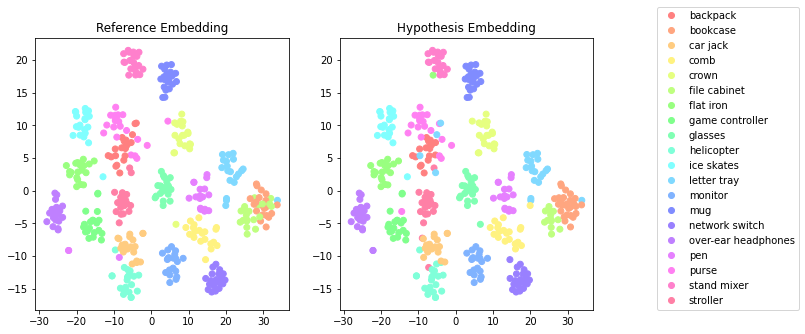

In [145]:
plot_features(e,ref,out,class_mapping,colormap)

## Finetune ResNet18 on P only

Here we train a model of ResNet18 on product images only

In [ ]:
net = Model(N_CLASSES).to(device)
optimizer = get_optimizer(net,lr=0.001, wd=0.000001, momentum=0.9)
net = train(net,train_loader_p,test_loader_p, 
         optimizer = optimizer,
         epochs=50, 
         device=device)

In [147]:
# save pre trained fine tuned model
torch.save(net, resnet18_p_path)

In [148]:
!cp $resnet18_p_path "gdrive/MyDrive/"

In [149]:
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 423), started 2:42:32 ago. (Use '!kill 423' to kill it.)

<IPython.core.display.Javascript object>

### Load

we load a pre computed model, useful to avoid retraining the model each time

In [150]:
# load
net = torch.load(resnet18_p_path)
net.to(device)
net.eval()

Model(
  (Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ReLU(inplace=True)): ReLU(inplace=True)
  (MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d

### Test Source
Here we test the model on the source (real life ) test set

In [151]:
# Source results P
cost_function = get_Ce_loss()
test_loss,test_accuracy,emb,out = test_step(net, test_loader_p, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [152]:
print(f"Test Loss P -> P: {test_loss}, Test Accuracy P -> P: {test_accuracy}")

Test Loss P -> P: 0.0013545748963952064, Test Accuracy P -> P: 96.25


In [153]:
ref = ref_labels(test_loader_p)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


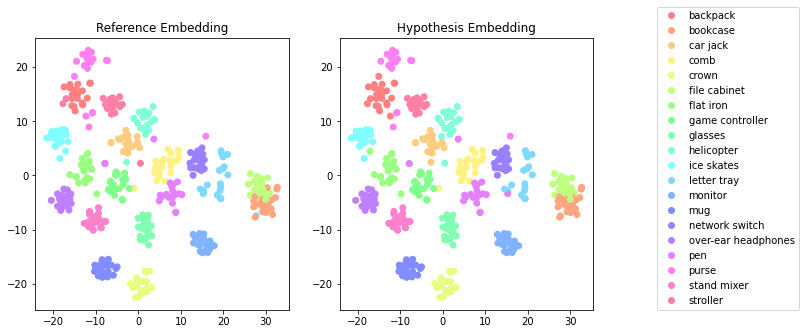

In [154]:
plot_features(e,ref,out,class_mapping,colormap)

### Test Target

Here we test the trained model on the target (product images) test set

In [155]:
# Target results P -> R
cost_function = get_ce_loss()
test_loss, test_accuracy,emb,out = test_step(net, test_loader_r, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [156]:
print(f"Test Loss P -> R: {test_loss}, Test Accuracy P -> R: {test_accuracy}")

Test Loss P -> R: 0.010508234053850174, Test Accuracy P -> R: 72.25


In [157]:
ref = ref_labels(test_loader_r)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


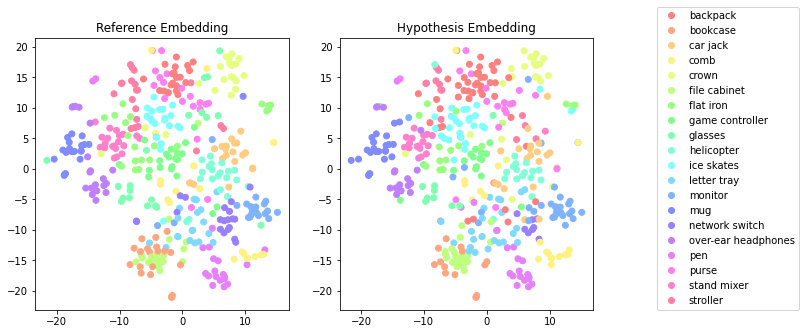

In [158]:
plot_features(e,ref,out,class_mapping,colormap)

# 2. Simple MMD

Here we test the simple ResNET18 with a simple Domain adaptation strategy based on Maximum Mean Discrepancy. Two losses of Cross Entropy and Maximum Mean Discrepancy are used.

In [77]:
def training_step(net, 
                  source_data_loader, target_data_loader, 
                  optimizer,
                  ce_cost_fun,mmd_cost_fun,
                  mmd_loss_weight,
                  device='cuda:0'):
  source_samples = 0.
  target_samples = 0.
  cumulative_ce_loss = 0.
  cumulative_mmd_loss = 0.
  cumulative_accuracy = 0.
  target_iter = iter(target_data_loader)
  # strictly needed if network contains layers which has different behaviours between train and test
  net.train()
  for batch_idx, (inputs_source, targets) in enumerate(source_data_loader):
    # get target data. If the target iterator reaches the end, restart it
    try:
      inputs_target, _ = next(target_iter)
    except:
      target_iter = iter(target_data_loader)
      inputs_target, _ = next(target_iter)
    inputs = torch.cat((inputs_source, inputs_target), dim=0)
    # loads data inot gpu
    inputs = inputs.to(device)
    targets = targets.to(device)
    # forward pass. I require in out the embeddings of the last layer(8)
    outputs,features = net(inputs,[8])
    features = features[0].squeeze()
    # split the source and target outputs
    source_output, target_output = torch.split(outputs, 
                                               split_size_or_sections=outputs.shape[0] // 2, 
                                               dim=0)
    source_features, target_features = torch.split(features, 
                                            split_size_or_sections=features.shape[0] // 2, 
                                            dim=0)
    # apply the losses
    ce_loss = ce_cost_fun(source_output,targets)
    mmd_loss = mmd_cost_fun(source_features,target_features)
    loss = ce_loss + mmd_loss_weight * mmd_loss
    # backward pass
    loss.backward()
    # update parameters
    optimizer.step()
    # reset the optimizer
    optimizer.zero_grad()
    # print statistics
    source_samples+=inputs_source.shape[0]
    target_samples+=inputs_target.shape[0]
    cumulative_ce_loss += ce_loss.item()
    cumulative_mmd_loss += mmd_loss.item()
    _, predicted = source_output.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_ce_loss/source_samples, cumulative_mmd_loss/target_samples, cumulative_accuracy/source_samples*100


In [78]:
def train(net,
          source_train_loader,
          source_test_loader,
          target_train_loader,
          target_test_loader,
          optimizer,
          epochs,
          mmd_loss_weight=1,
          device='cuda:0'):
  writer = SummaryWriter(log_dir="runs/mmd")
  # instantiates the cost functions
  ce_cost_function = get_ce_loss()
  mmd_cost_function = get_mmd_loss()
  # range over the number of epochs
  pbar = tqdm(range(epochs),position=0, leave=True)
  for e in pbar:
    ce_train_loss,mmd_train_loss, train_accuracy = training_step(net, source_train_loader,target_train_loader,
                                                                 optimizer, 
                                                                 ce_cost_function,mmd_cost_function,
                                                                 mmd_loss_weight=mmd_loss_weight,
                                                                 device=device)
    source_test_loss, source_test_accuracy = test_step(net, source_test_loader, ce_cost_function,device=device)
    target_test_loss, target_test_accuracy = test_step(net, target_test_loader, ce_cost_function,device=device)
    pbar.set_description(str({
    'CE Training loss': f'{ce_train_loss:.5f}',
    'MMD Training loss': f'{mmd_train_loss:.5f}',
    'Training accuracy': f'{train_accuracy:.2f}',    
    'Source Test loss': f'{source_test_loss:.5f}',
    'Source Test accuracy': f'{source_test_accuracy:.2f}',    
    'Target Test loss': f'{target_test_loss:.5f}',
    'Target Test accuracy': f'{target_test_accuracy:.2f}',
    }))
    # add values to logger
    writer.add_scalar('Loss/ce_train_loss', ce_train_loss, e)
    writer.add_scalar('Loss/mmd_train_loss', mmd_train_loss, e)
    writer.add_scalar('Loss/source_test_loss', source_test_loss, e)
    writer.add_scalar('Loss/target_test_loss', target_test_loss, e)
    writer.add_scalar('Accuracy/train_accuracy', train_accuracy, e)
    writer.add_scalar('Accuracy/source_test_accuracy', source_test_accuracy, e)
    writer.add_scalar('Accuracy/target_test_accuracy', target_test_accuracy, e)
  # close the logger
  writer.close()
  return net

## Finetune ResNet18 on R -> P

We train a model of ResNet18 on real life to product 

In [79]:
net = Model(N_CLASSES).to(device)
optimizer = get_optimizer(net,lr=0.001, wd=0.000001, momentum=0.9)
net = train(net,
            source_train_loader=train_loader_r,source_test_loader=test_loader_r,
            target_train_loader=train_loader_p,target_test_loader=test_loader_p, 
         optimizer = optimizer,
         epochs=50, 
         mmd_loss_weight=100,
         device=device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
{'CE Training loss': '0.00141', 'MMD Training loss': '0.00055', 'Training accuracy': '98.56', 'Source Test loss': '0.00371', 'Source Test accuracy': '91.25', 'Target Test loss': '0.00335', 'Target Test accuracy': '92.25'}: 100%|██████████| 50/50 [05:15<00:00,  6.32s/it]


In [80]:
# save
torch.save(net, resnet18_mmd_r_p_path)

In [81]:
!cp $resnet18_mmd_r_p_path "gdrive/MyDrive/"

In [82]:
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 423), started 1:15:07 ago. (Use '!kill 423' to kill it.)

<IPython.core.display.Javascript object>

### Load

we load a pre computed model, useful to avoid retraining the model each time

In [83]:
# load pre trained fine tuned model
net = torch.load(resnet18_mmd_r_p_path)
net.to(device)
net.eval()

Model(
  (Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ReLU(inplace=True)): ReLU(inplace=True)
  (MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d

### Test Source
Here we test the model on the source (real life ) test set

In [84]:
# Source results R
cost_function = get_ce_loss()
test_loss,test_accuracy,emb,out = test_step(net, test_loader_r, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [85]:
print(f"Test Loss R -> R: {test_loss}, Test Accuracy R -> R: {test_accuracy}")

Test Loss R -> R: 0.0037103236839175226, Test Accuracy R -> R: 91.25


In [86]:
ref = ref_labels(test_loader_r)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


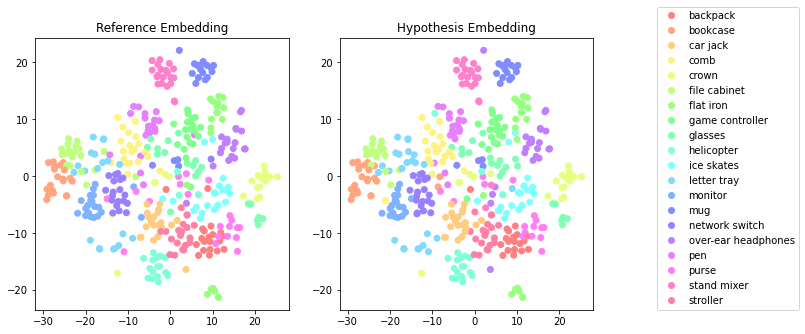

In [87]:
plot_features(e,ref,out,class_mapping,colormap)

### Test Target

Here we test the trained model on the target (product images) test set

In [88]:
# Target results R -> P
cost_function = get_ce_loss()
test_loss, test_accuracy,emb,out = test_step(net, test_loader_p, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [89]:
print(f"Test Loss R -> P: {test_loss}, Test Accuracy R -> P: {test_accuracy}")

Test Loss R -> P: 0.0033520421385765074, Test Accuracy R -> P: 92.25


In [90]:
ref = ref_labels(test_loader_p)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


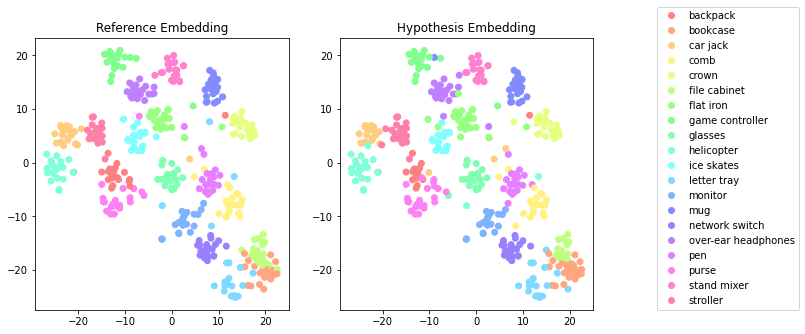

In [91]:
plot_features(e,ref,out,class_mapping,colormap)

## Finetune ResNet18 on P -> R

In [92]:
net = Model(N_CLASSES).to(device)
optimizer = get_optimizer(net,lr=0.001, wd=0.000001, momentum=0.9)
net = train(net,
            source_train_loader=train_loader_p,source_test_loader=test_loader_p,
            target_train_loader=train_loader_r,target_test_loader=test_loader_r, 
         optimizer = optimizer,
         epochs=50, 
         mmd_loss_weight=100,
         device=device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
{'CE Training loss': '0.00070', 'MMD Training loss': '0.00055', 'Training accuracy': '99.69', 'Source Test loss': '0.00166', 'Source Test accuracy': '98.25', 'Target Test loss': '0.00688', 'Target Test accuracy': '79.50'}: 100%|██████████| 50/50 [05:13<00:00,  6.27s/it]


In [93]:
# save
torch.save(net,resnet18_mmd_p_r_path)

In [94]:
!cp $resnet18_mmd_p_r_path "gdrive/MyDrive/"

In [95]:
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 423), started 1:20:28 ago. (Use '!kill 423' to kill it.)

<IPython.core.display.Javascript object>

### Load

we load a pre computed model, useful to avoid retraining the model each time

In [96]:
# load pre trained fine tuned model
net = torch.load(resnet18_mmd_p_r_path)
net.to(device)
net.eval()

Model(
  (Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ReLU(inplace=True)): ReLU(inplace=True)
  (MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d

### Test Source
Here we test the model on the source (real life ) test set

In [97]:
# Source results P
cost_function = get_ce_loss()
test_loss,test_accuracy,emb,out = test_step(net, test_loader_p, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [98]:
print(f"Test Loss P -> P: {test_loss}, Test Accuracy P -> P: {test_accuracy}")

Test Loss P -> P: 0.001660267487168312, Test Accuracy P -> P: 98.25


In [99]:
ref = ref_labels(test_loader_p)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


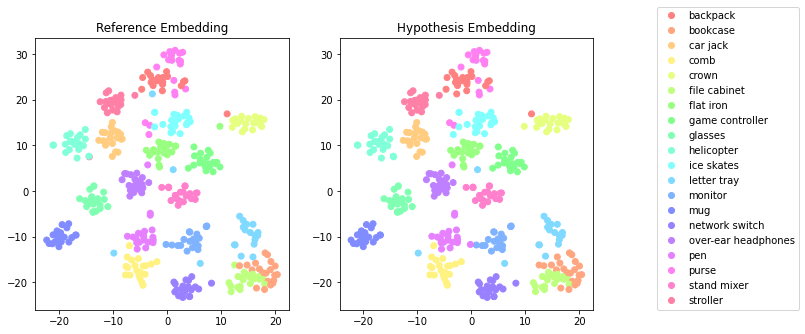

In [100]:
plot_features(e,ref,out,class_mapping,colormap)

### Test Target

Here we test the trained model on the target (product images) test set

In [101]:
# Target results P -> R
cost_function = get_ce_loss()
test_loss, test_accuracy,emb,out = test_step(net, test_loader_r, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [102]:
print(f"Test Loss P -> R: {test_loss}, Test Accuracy P -> R: {test_accuracy}")

Test Loss P -> R: 0.006877278462052345, Test Accuracy P -> R: 79.5


In [103]:
ref = ref_labels(test_loader_r)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


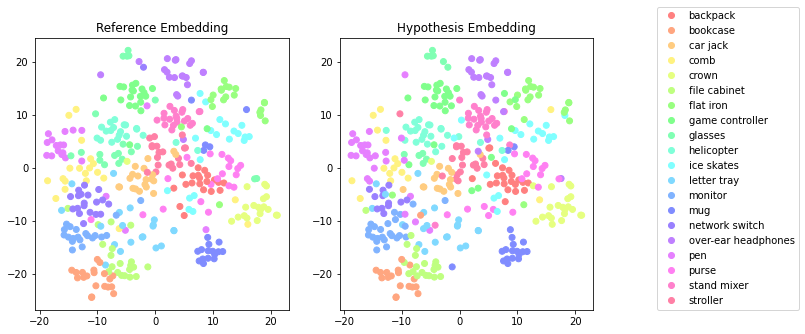

In [104]:
plot_features(e,ref,out,class_mapping,colormap)

# 3. Simple CORAL

Here we test the simple ResNET18 with a simple Domain adaptation strategy based on Correlation Alignment. Two losses of Cross Entropy and CORAL are used

In [44]:
def training_step(net, 
                  source_data_loader, target_data_loader, 
                  optimizer,
                  ce_cost_fun,coral_cost_fun, 
                  coral_loss_weight, 
                  device='cuda:0'):
  source_samples = 0.
  target_samples = 0.
  cumulative_ce_loss = 0.
  cumulative_coral_loss = 0.
  cumulative_accuracy = 0.
  target_iter = iter(target_data_loader)
  # strictly needed if network contains layers which has different behaviours between train and test
  net.train()
  for batch_idx, (inputs_source, targets) in enumerate(source_data_loader):
    # get target data. If the target iterator reaches the end, restart it
    try:
      inputs_target, _ = next(target_iter)
    except:
      target_iter = iter(target_data_loader)
      inputs_target, _ = next(target_iter)
    inputs = torch.cat((inputs_source, inputs_target), dim=0)
    # loads data inot gpu
    inputs = inputs.to(device)
    targets = targets.to(device)
    # forward pass. I require in out the embeddings of the last layer(8)
    outputs,features = net(inputs,[8])
    features = features[0].squeeze()
    # split the source and target outputs
    source_output, target_output = torch.split(outputs, 
                                               split_size_or_sections=outputs.shape[0] // 2, 
                                               dim=0)
    source_features, target_features = torch.split(features, 
                                            split_size_or_sections=features.shape[0] // 2, 
                                            dim=0)
    # apply the losses
    ce_loss = ce_cost_fun(source_output,targets)
    coral_loss = coral_cost_fun(source_features,target_features)
    loss = ce_loss + coral_loss_weight * coral_loss
    # backward pass
    loss.backward()
    # update parameters
    optimizer.step()
    # reset the optimizer
    optimizer.zero_grad()
    # print statistics
    source_samples+=inputs_source.shape[0]
    target_samples+=inputs_target.shape[0]
    cumulative_ce_loss += ce_loss.item()
    cumulative_coral_loss += coral_loss.item()
    _, predicted = source_output.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_ce_loss/source_samples, cumulative_coral_loss/target_samples, cumulative_accuracy/source_samples*100


In [45]:
def train(net,
          source_train_loader,
          source_test_loader,
          target_train_loader,
          target_test_loader,
          optimizer,
          epochs,
          coral_loss_weight=1,
          device='cuda:0'):
  writer = SummaryWriter(log_dir="runs/coral")
  # instantiates the cost functions
  ce_cost_function = get_ce_loss()
  coral_cost_function = get_coral_loss()
  # range over the number of epochs
  pbar = tqdm(range(epochs),position=0, leave=True)
  for e in pbar:
    ce_train_loss,coral_train_loss, train_accuracy = training_step(net, source_train_loader,target_train_loader,
                                                                 optimizer, 
                                                                 ce_cost_function,coral_cost_function,
                                                                 coral_loss_weight=coral_loss_weight,
                                                                 device=device)
    source_test_loss, source_test_accuracy = test_step(net, source_test_loader, ce_cost_function,device=device)
    target_test_loss, target_test_accuracy = test_step(net, target_test_loader, ce_cost_function,device=device)
    pbar.set_description(str({
    'CE Training loss': f'{ce_train_loss:.5f}',
    'CORAL Training loss': f'{coral_train_loss:.5f}',
    'Training accuracy': f'{train_accuracy:.2f}',    
    'Source Test loss': f'{source_test_loss:.5f}',
    'Source Test accuracy': f'{source_test_accuracy:.2f}',    
    'Target Test loss': f'{target_test_loss:.5f}',
    'Target Test accuracy': f'{target_test_accuracy:.2f}',
    }))
    # add values to logger
    writer.add_scalar('Loss/ce_train_loss', ce_train_loss, e)
    writer.add_scalar('Loss/coral_train_loss', coral_train_loss, e)
    writer.add_scalar('Loss/source_test_loss', source_test_loss, e)
    writer.add_scalar('Loss/target_test_loss', target_test_loss, e)
    writer.add_scalar('Accuracy/train_accuracy', train_accuracy, e)
    writer.add_scalar('Accuracy/source_test_accuracy', source_test_accuracy, e)
    writer.add_scalar('Accuracy/target_test_accuracy', target_test_accuracy, e)
  # close the logger
  writer.close()
  return net

## Finetune ResNet18 on R -> P

We train a model of ResNet18 on real life to product 

In [46]:
net = Model(N_CLASSES).to(device)
optimizer = get_optimizer(net,lr=0.001, wd=0.000001, momentum=0.9)
net = train(net,
            source_train_loader=train_loader_r,source_test_loader=test_loader_r,
            target_train_loader=train_loader_p,target_test_loader=test_loader_p, 
         optimizer = optimizer,
         epochs=50, 
         coral_loss_weight=100,
         device=device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
{'CE Training loss': '0.00142', 'CORAL Training loss': '0.00005', 'Training accuracy': '99.00', 'Source Test loss'

In [47]:
# save
torch.save(net, resnet18_coral_r_p_path)

In [48]:
!cp $resnet18_coral_r_p_path "gdrive/MyDrive/"

In [49]:
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 423), started 1:57:08 ago. (Use '!kill 423' to kill it.)

<IPython.core.display.Javascript object>

### Load

we load a pre computed model, useful to avoid retraining the model each time

In [50]:
# load pre trained fine tuned model
net = torch.load(resnet18_coral_r_p_path)
net.to(device)
net.eval()

Model(
  (Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ReLU(inplace=True)): ReLU(inplace=True)
  (MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d

### Test Source
Here we test the model on the source (real life ) test set

In [51]:
# Source results R
cost_function = get_ce_loss()
test_loss,test_accuracy,emb,out = test_step(net, test_loader_r, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [52]:
print(f"Test Loss R -> R: {test_loss}, Test Accuracy R -> R: {test_accuracy}")

Test Loss R -> R: 0.005030035898089409, Test Accuracy R -> R: 85.75


In [53]:
ref = ref_labels(test_loader_r)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


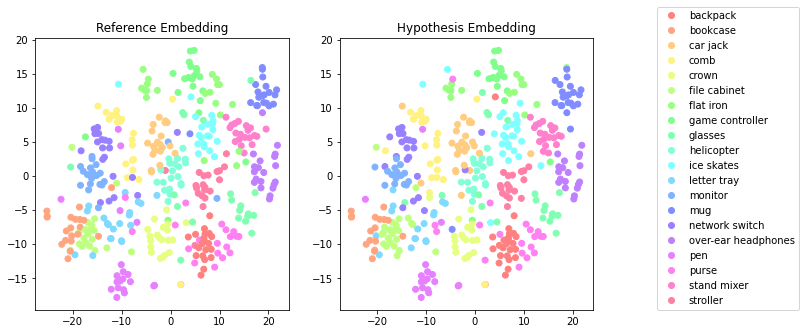

In [54]:
plot_features(e,ref,out,class_mapping,colormap)

### Test Target

Here we test the trained model on the target (product images) test set

In [55]:
# Target results R -> P
cost_function = get_ce_loss()
test_loss, test_accuracy,emb,out = test_step(net, test_loader_p, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [56]:
print(f"Test Loss R -> P: {test_loss}, Test Accuracy R -> P: {test_accuracy}")

Test Loss R -> P: 0.004055058285593986, Test Accuracy R -> P: 91.5


In [57]:
ref = ref_labels(test_loader_p)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


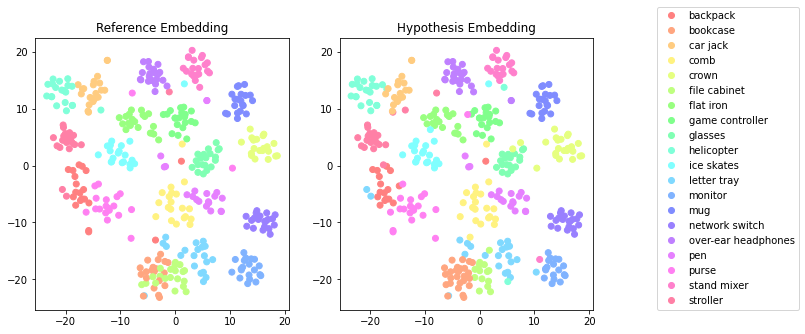

In [58]:
plot_features(e,ref,out,class_mapping,colormap)

## Finetune ResNet18 on P -> R

In [59]:
net = Model(N_CLASSES).to(device)
optimizer = get_optimizer(net,lr=0.001, wd=0.000001, momentum=0.9)
net = train(net,
            source_train_loader=train_loader_p,source_test_loader=test_loader_p,
            target_train_loader=train_loader_r,target_test_loader=test_loader_r, 
         optimizer = optimizer,
         epochs=50, 
         coral_loss_weight=100,
         device=device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
{'CE Training loss': '0.00080', 'CORAL Training loss': '0.00005', 'Training accuracy': '99.62', 'Source Test loss'

In [60]:
# save
torch.save(net,resnet18_coral_p_r_path)

In [61]:
!cp $resnet18_coral_p_r_path "gdrive/MyDrive/"

In [62]:
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 423), started 2:02:28 ago. (Use '!kill 423' to kill it.)

<IPython.core.display.Javascript object>

### Load

we load a pre computed model, useful to avoid retraining the model each time

In [63]:
# load pre trained fine tuned model
net = torch.load(resnet18_coral_p_r_path)
net.to(device)
net.eval()

Model(
  (Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ReLU(inplace=True)): ReLU(inplace=True)
  (MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d

### Test Source
Here we test the model on the source (real life ) test set

In [64]:
# Source results P
cost_function = get_ce_loss()
test_loss,test_accuracy,emb,out = test_step(net, test_loader_p, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [65]:
print(f"Test Loss P -> P: {test_loss}, Test Accuracy P -> P: {test_accuracy}")

Test Loss P -> P: 0.0017586923018097877, Test Accuracy P -> P: 95.75


In [66]:
ref = ref_labels(test_loader_p)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


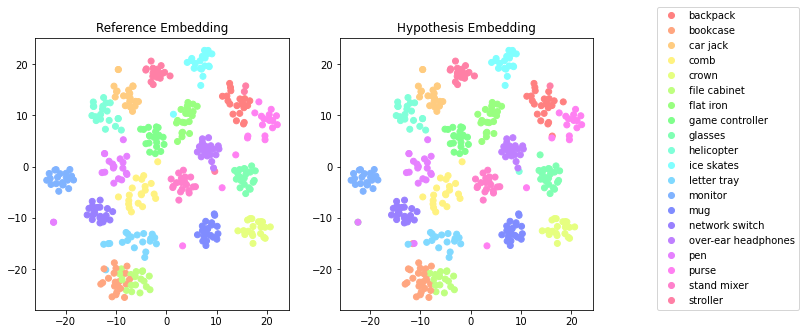

In [67]:
plot_features(e,ref,out,class_mapping,colormap)

### Test Target

Here we test the trained model on the target (product images) test set

In [68]:
# Target results P -> R
cost_function = get_ce_loss()
test_loss, test_accuracy,emb,out = test_step(net, test_loader_r, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [69]:
print(f"Test Loss P -> R: {test_loss}, Test Accuracy P -> R: {test_accuracy}")

Test Loss P -> R: 0.009110996723175049, Test Accuracy P -> R: 78.75


In [70]:
ref = ref_labels(test_loader_r)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


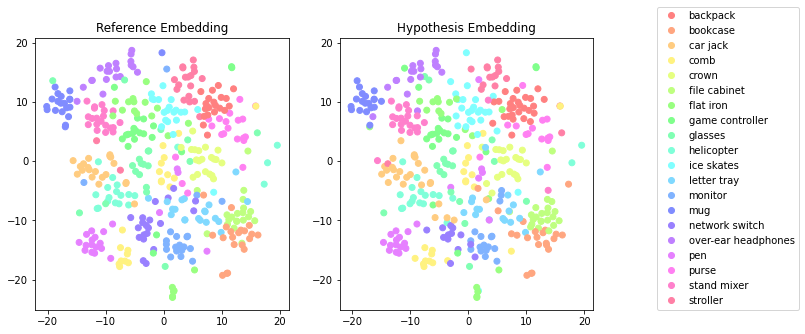

In [71]:
plot_features(e,ref,out,class_mapping,colormap)

# 3. Label CORAL

Here we test the simple ResNET18 with a simple Domain adaptation strategy based on Correlation Alignment. Two losses of Cross Entropy and CORAL are used

In [20]:
def training_step(net, 
                  source_data_loader, target_data_loader, 
                  optimizer,
                  ce_cost_fun,coral_cost_fun, 
                  coral_loss_weight, 
                  device='cuda:0'):
  source_samples = 0.
  target_samples = 0.
  cumulative_ce_loss = 0.
  cumulative_coral_loss = 0.
  cumulative_accuracy = 0.
  target_iter = iter(target_data_loader)
  # strictly needed if network contains layers which has different behaviours between train and test
  net.train()
  for batch_idx, (inputs_source, targets) in enumerate(source_data_loader):
    # get target data. If the target iterator reaches the end, restart it
    try:
      inputs_target, _ = next(target_iter)
    except:
      target_iter = iter(target_data_loader)
      inputs_target, _ = next(target_iter)
    inputs = torch.cat((inputs_source, inputs_target), dim=0)
    # loads data inot gpu
    inputs = inputs.to(device)
    targets = targets.to(device)
    # forward pass. I require in out the embeddings of the last layer(8)
    outputs,features = net(inputs,[8])
    features = features[0].squeeze()
    # split the source and target outputs
    source_output, target_output = torch.split(outputs, 
                                               split_size_or_sections=outputs.shape[0] // 2, 
                                               dim=0)
    source_features, target_features = torch.split(features, 
                                            split_size_or_sections=features.shape[0] // 2, 
                                            dim=0)
    # apply the losses
    ce_loss = ce_cost_fun(source_output,targets)
    coral_loss = coral_cost_fun(source_features,target_features,targets,torch.argmax(target_output,dim=1),net.fc.out_features)
    loss = ce_loss + coral_loss_weight * coral_loss
    # backward pass
    loss.backward()
    # update parameters
    optimizer.step()
    # reset the optimizer
    optimizer.zero_grad()
    # print statistics
    source_samples+=inputs_source.shape[0]
    target_samples+=inputs_target.shape[0]
    cumulative_ce_loss += ce_loss.item()
    cumulative_coral_loss += coral_loss.item()
    _, predicted = source_output.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_ce_loss/source_samples, cumulative_coral_loss/target_samples, cumulative_accuracy/source_samples*100


In [21]:
def train(net,
          source_train_loader,
          source_test_loader,
          target_train_loader,
          target_test_loader,
          optimizer,
          epochs,
          coral_loss_weight=1,
          device='cuda:0'):
  writer = SummaryWriter(log_dir="runs/coral")
  # instantiates the cost functions
  ce_cost_function = get_ce_loss()
  coral_cost_function = get_label_coral_loss()
  # range over the number of epochs
  pbar = tqdm(range(epochs),position=0, leave=True)
  for e in pbar:
    ce_train_loss,coral_train_loss, train_accuracy = training_step(net, source_train_loader,target_train_loader,
                                                                 optimizer, 
                                                                 ce_cost_function,coral_cost_function,
                                                                 coral_loss_weight=coral_loss_weight,
                                                                 device=device)
    source_test_loss, source_test_accuracy = test_step(net, source_test_loader, ce_cost_function,device=device)
    target_test_loss, target_test_accuracy = test_step(net, target_test_loader, ce_cost_function,device=device)
    pbar.set_description(str({
    'CE Training loss': f'{ce_train_loss:.5f}',
    'CORAL Training loss': f'{coral_train_loss:.5f}',
    'Training accuracy': f'{train_accuracy:.2f}',    
    'Source Test loss': f'{source_test_loss:.5f}',
    'Source Test accuracy': f'{source_test_accuracy:.2f}',    
    'Target Test loss': f'{target_test_loss:.5f}',
    'Target Test accuracy': f'{target_test_accuracy:.2f}',
    }))
    # add values to logger
    writer.add_scalar('Loss/ce_train_loss', ce_train_loss, e)
    writer.add_scalar('Loss/coral_train_loss', coral_train_loss, e)
    writer.add_scalar('Loss/source_test_loss', source_test_loss, e)
    writer.add_scalar('Loss/target_test_loss', target_test_loss, e)
    writer.add_scalar('Accuracy/train_accuracy', train_accuracy, e)
    writer.add_scalar('Accuracy/source_test_accuracy', source_test_accuracy, e)
    writer.add_scalar('Accuracy/target_test_accuracy', target_test_accuracy, e)
  # close the logger
  writer.close()
  return net

## Finetune ResNet18 on R -> P

We train a model of ResNet18 on real life to product 

In [22]:
net = Model(N_CLASSES).to(device)
optimizer = get_optimizer(net,lr=0.001, wd=0.000001, momentum=0.9)
net = train(net,
            source_train_loader=train_loader_r,source_test_loader=test_loader_r,
            target_train_loader=train_loader_p,target_test_loader=test_loader_p, 
         optimizer = optimizer,
         epochs=50, 
         coral_loss_weight=0.25,
         device=device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
{'CE Training loss': '0.00135', 'CORAL Training loss': '0.02000', 'Training accuracy': '98.69', 'Source Test loss'

In [25]:
# save
torch.save(net, resnet18_label_coral_r_p_path)

In [26]:
!cp $resnet18_label_coral_r_p_path "gdrive/MyDrive/"

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

### Load

we load a pre computed model, useful to avoid retraining the model each time

In [27]:
# load pre trained fine tuned model
net = torch.load(resnet18_label_coral_r_p_path)
net.to(device)
net.eval()

Model(
  (Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ReLU(inplace=True)): ReLU(inplace=True)
  (MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d

### Test Source
Here we test the model on the source (real life ) test set

In [28]:
# Source results R
cost_function = get_ce_loss()
test_loss,test_accuracy,emb,out = test_step(net, test_loader_r, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [29]:
print(f"Test Loss R -> R: {test_loss}, Test Accuracy R -> R: {test_accuracy}")

Test Loss R -> R: 0.0035323044657707215, Test Accuracy R -> R: 90.5


In [30]:
ref = ref_labels(test_loader_r)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


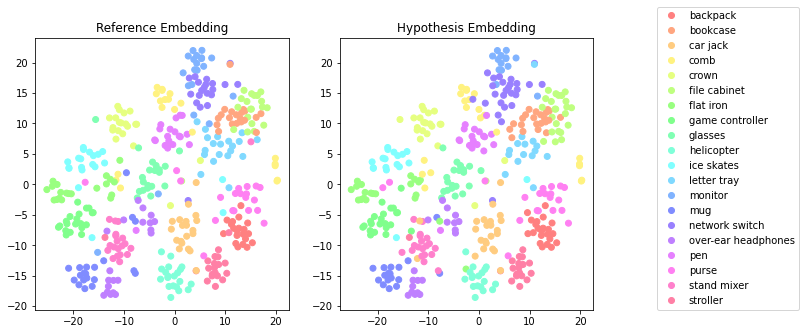

In [31]:
plot_features(e,ref,out,class_mapping,colormap)

### Test Target

Here we test the trained model on the target (product images) test set

In [32]:
# Target results R -> P
cost_function = get_ce_loss()
test_loss, test_accuracy,emb,out = test_step(net, test_loader_p, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [33]:
print(f"Test Loss R -> P: {test_loss}, Test Accuracy R -> P: {test_accuracy}")

Test Loss R -> P: 0.0035353557020425795, Test Accuracy R -> P: 93.0


In [34]:
ref = ref_labels(test_loader_p)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


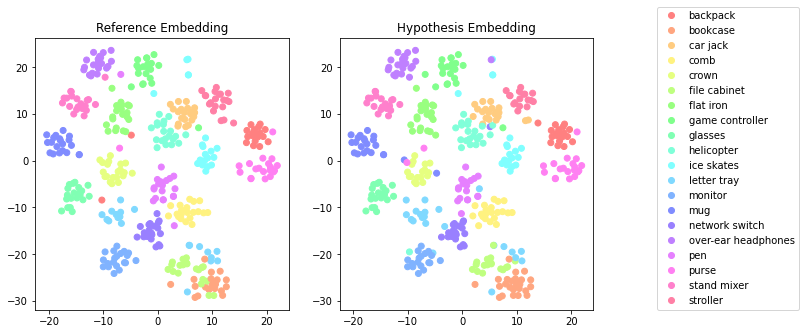

In [35]:
plot_features(e,ref,out,class_mapping,colormap)

## Finetune ResNet18 on P -> R

In [36]:
net = Model(N_CLASSES).to(device)
optimizer = get_optimizer(net,lr=0.001, wd=0.000001, momentum=0.9)
net = train(net,
            source_train_loader=train_loader_p,source_test_loader=test_loader_p,
            target_train_loader=train_loader_r,target_test_loader=test_loader_r, 
         optimizer = optimizer,
         epochs=50, 
         coral_loss_weight=0.25,
         device=device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
{'CE Training loss': '0.00077', 'CORAL Training loss': '0.02019', 'Training accuracy': '99.56', 'Source Test loss'

In [37]:
# save
torch.save(net,resnet18_label_coral_p_r_path)

In [38]:
!cp $resnet18_label_coral_p_r_path "gdrive/MyDrive/"

In [39]:
%load_ext tensorboard
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 423), started 8:11:34 ago. (Use '!kill 423' to kill it.)

<IPython.core.display.Javascript object>

### Load

we load a pre computed model, useful to avoid retraining the model each time

In [40]:
# load pre trained fine tuned model
net = torch.load(resnet18_label_coral_p_r_path)
net.to(device)
net.eval()

Model(
  (Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ReLU(inplace=True)): ReLU(inplace=True)
  (MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d

### Test Source
Here we test the model on the source (real life ) test set

In [41]:
# Source results P
cost_function = get_ce_loss()
test_loss,test_accuracy,emb,out = test_step(net, test_loader_p, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [42]:
print(f"Test Loss P -> P: {test_loss}, Test Accuracy P -> P: {test_accuracy}")

Test Loss P -> P: 0.002062091529369354, Test Accuracy P -> P: 96.25


In [43]:
ref = ref_labels(test_loader_p)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


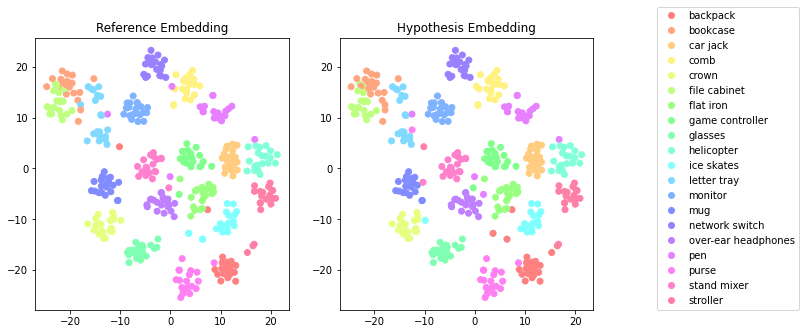

In [44]:
plot_features(e,ref,out,class_mapping,colormap)

### Test Target

Here we test the trained model on the target (product images) test set

In [45]:
# Target results P -> R
cost_function = get_ce_loss()
test_loss, test_accuracy,emb,out = test_step(net, test_loader_r, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [46]:
print(f"Test Loss P -> R: {test_loss}, Test Accuracy P -> R: {test_accuracy}")

Test Loss P -> R: 0.006225539892911911, Test Accuracy P -> R: 80.75


In [47]:
ref = ref_labels(test_loader_r)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


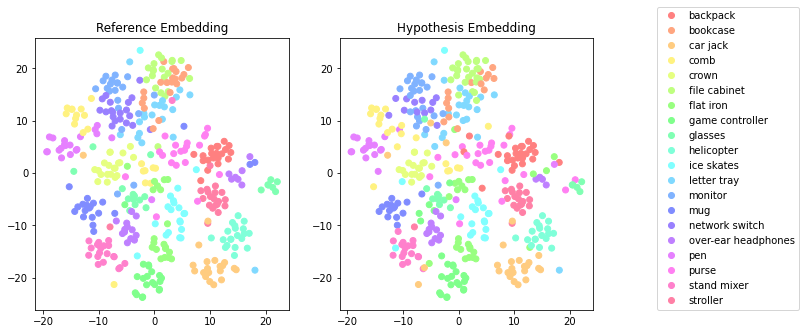

In [48]:
plot_features(e,ref,out,class_mapping,colormap)

# 3. Triplet Margin Distance Loss

Here we test the simple ResNET18 with a simple Domain adaptation strategy based on Correlation Alignment. Two losses of Cross Entropy and CORAL are used

In [50]:
def training_step(net, 
                  source_data_loader, target_data_loader, 
                  optimizer,
                  ce_cost_fun,coral_cost_fun, 
                  coral_loss_weight, 
                  device='cuda:0'):
  source_samples = 0.
  target_samples = 0.
  cumulative_ce_loss = 0.
  cumulative_coral_loss = 0.
  cumulative_accuracy = 0.
  target_iter = iter(target_data_loader)
  # strictly needed if network contains layers which has different behaviours between train and test
  net.train()
  for batch_idx, (inputs_source, targets) in enumerate(source_data_loader):
    # get target data. If the target iterator reaches the end, restart it
    try:
      inputs_target, _ = next(target_iter)
    except:
      target_iter = iter(target_data_loader)
      inputs_target, _ = next(target_iter)
    inputs = torch.cat((inputs_source, inputs_target), dim=0)
    # loads data inot gpu
    inputs = inputs.to(device)
    targets = targets.to(device)
    # forward pass. I require in out the embeddings of the last layer(8)
    outputs,features = net(inputs,[8])
    features = features[0].squeeze()
    # split the source and target outputs
    source_output, target_output = torch.split(outputs, 
                                               split_size_or_sections=outputs.shape[0] // 2, 
                                               dim=0)
    source_features, target_features = torch.split(features, 
                                            split_size_or_sections=features.shape[0] // 2, 
                                            dim=0)
    # apply the losses
    ce_loss = ce_cost_fun(source_output,targets)
    coral_loss = coral_cost_fun(source_features,target_features,targets,torch.argmax(target_output,dim=1),net.fc.out_features)
    loss = ce_loss + coral_loss_weight * coral_loss
    # backward pass
    loss.backward()
    # update parameters
    optimizer.step()
    # reset the optimizer
    optimizer.zero_grad()
    # print statistics
    source_samples+=inputs_source.shape[0]
    target_samples+=inputs_target.shape[0]
    cumulative_ce_loss += ce_loss.item()
    cumulative_coral_loss += coral_loss
    _, predicted = source_output.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_ce_loss/source_samples, cumulative_coral_loss/target_samples, cumulative_accuracy/source_samples*100


In [21]:
def train(net,
          source_train_loader,
          source_test_loader,
          target_train_loader,
          target_test_loader,
          optimizer,
          epochs,
          coral_loss_weight=1,
          device='cuda:0'):
  writer = SummaryWriter(log_dir="runs/coral")
  # instantiates the cost functions
  ce_cost_function = get_ce_loss()
  coral_cost_function = get_trmd_loss()
  # range over the number of epochs
  pbar = tqdm(range(epochs),position=0, leave=True)
  for e in pbar:
    ce_train_loss,coral_train_loss, train_accuracy = training_step(net, source_train_loader,target_train_loader,
                                                                 optimizer, 
                                                                 ce_cost_function,coral_cost_function,
                                                                 coral_loss_weight=coral_loss_weight,
                                                                 device=device)
    source_test_loss, source_test_accuracy = test_step(net, source_test_loader, ce_cost_function,device=device)
    target_test_loss, target_test_accuracy = test_step(net, target_test_loader, ce_cost_function,device=device)
    pbar.set_description(str({
    'CE Training loss': f'{ce_train_loss:.5f}',
    'CORAL Training loss': f'{coral_train_loss:.5f}',
    'Training accuracy': f'{train_accuracy:.2f}',    
    'Source Test loss': f'{source_test_loss:.5f}',
    'Source Test accuracy': f'{source_test_accuracy:.2f}',    
    'Target Test loss': f'{target_test_loss:.5f}',
    'Target Test accuracy': f'{target_test_accuracy:.2f}',
    }))
    # add values to logger
    writer.add_scalar('Loss/ce_train_loss', ce_train_loss, e)
    writer.add_scalar('Loss/coral_train_loss', coral_train_loss, e)
    writer.add_scalar('Loss/source_test_loss', source_test_loss, e)
    writer.add_scalar('Loss/target_test_loss', target_test_loss, e)
    writer.add_scalar('Accuracy/train_accuracy', train_accuracy, e)
    writer.add_scalar('Accuracy/source_test_accuracy', source_test_accuracy, e)
    writer.add_scalar('Accuracy/target_test_accuracy', target_test_accuracy, e)
  # close the logger
  writer.close()
  return net

## Finetune ResNet18 on R -> P

We train a model of ResNet18 on real life to product 

In [68]:
net = Model(N_CLASSES).to(device)
optimizer = get_optimizer(net,lr=0.001, wd=0.000001, momentum=0.9)
net = train(net,
            source_train_loader=train_loader_r,source_test_loader=test_loader_r,
            target_train_loader=train_loader_p,target_test_loader=test_loader_p, 
         optimizer = optimizer,
         epochs=50, 
         coral_loss_weight=0.1,
         device=device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
{'CE Training loss': '0.00089', 'CORAL Training loss': '0.00704', 'Training accuracy': '99.38', 'Source Test loss': '0.00416', 'Source Test accuracy': '89.50', 'Target Test loss': '0.00437', 'Target Test accuracy': '89.50'}: 100%|██████████| 50/50 [05:32<00:00,  6.66s/it]


In [69]:
# save
torch.save(net, resnet18_trmd_r_p_path)

In [70]:
!cp $resnet18_trmd_r_p_path "gdrive/MyDrive/"

In [71]:
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 423), started 9:48:45 ago. (Use '!kill 423' to kill it.)

<IPython.core.display.Javascript object>

### Load

we load a pre computed model, useful to avoid retraining the model each time

In [72]:
# load pre trained fine tuned model
net = torch.load(resnet18_trmd_r_p_path)
net.to(device)
net.eval()

Model(
  (Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ReLU(inplace=True)): ReLU(inplace=True)
  (MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d

### Test Source
Here we test the model on the source (real life ) test set

In [73]:
# Source results R
cost_function = get_ce_loss()
test_loss,test_accuracy,emb,out = test_step(net, test_loader_r, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [74]:
print(f"Test Loss R -> R: {test_loss}, Test Accuracy R -> R: {test_accuracy}")

Test Loss R -> R: 0.0041632973402738575, Test Accuracy R -> R: 89.5


In [75]:
ref = ref_labels(test_loader_r)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


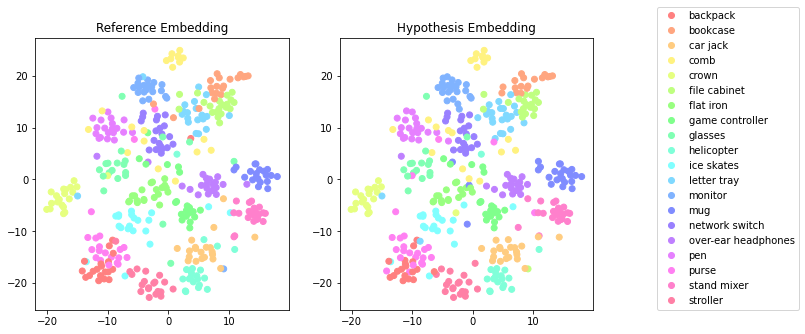

In [76]:
plot_features(e,ref,out,class_mapping,colormap)

### Test Target

Here we test the trained model on the target (product images) test set

In [77]:
# Target results R -> P
cost_function = get_ce_loss()
test_loss, test_accuracy,emb,out = test_step(net, test_loader_p, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [78]:
print(f"Test Loss R -> P: {test_loss}, Test Accuracy R -> P: {test_accuracy}")

Test Loss R -> P: 0.004373683035373688, Test Accuracy R -> P: 89.5


In [79]:
ref = ref_labels(test_loader_p)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


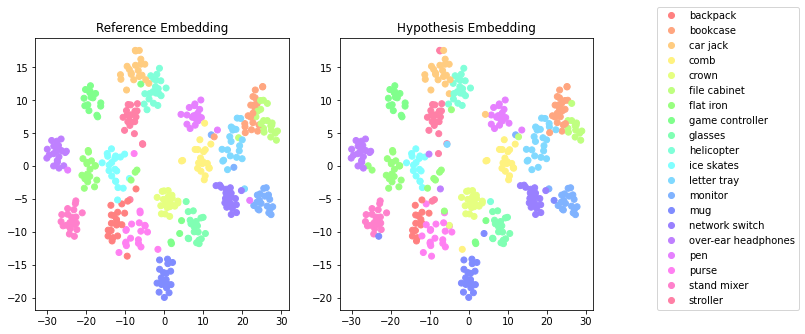

In [80]:
plot_features(e,ref,out,class_mapping,colormap)

## Finetune ResNet18 on P -> R

In [55]:
net = Model(N_CLASSES).to(device)
optimizer = get_optimizer(net,lr=0.001, wd=0.000001, momentum=0.9)
net = train(net,
            source_train_loader=train_loader_p,source_test_loader=test_loader_p,
            target_train_loader=train_loader_r,target_test_loader=test_loader_r, 
         optimizer = optimizer,
         epochs=50, 
         coral_loss_weight=0.1,
         device=device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
{'CE Training loss': '0.00042', 'CORAL Training loss': '0.01319', 'Training accuracy': '99.81', 'Source Test loss': '0.00156', 'Source Test accuracy': '96.50', 'Target Test loss': '0.00875', 'Target Test accuracy': '78.75'}: 100%|██████████| 50/50 [05:33<00:00,  6.67s/it]


In [56]:
# save
torch.save(net,resnet18_trmd_p_r_path)

In [57]:
!cp $resnet18_trmd_p_r_path "gdrive/MyDrive/"

In [58]:
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 423), started 9:43:06 ago. (Use '!kill 423' to kill it.)

<IPython.core.display.Javascript object>

### Load

we load a pre computed model, useful to avoid retraining the model each time

In [59]:
# load pre trained fine tuned model
net = torch.load(resnet18_trmd_p_r_path)
net.to(device)
net.eval()

Model(
  (Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ReLU(inplace=True)): ReLU(inplace=True)
  (MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d

### Test Source
Here we test the model on the source (real life ) test set

In [60]:
# Source results P
cost_function = get_ce_loss()
test_loss,test_accuracy,emb,out = test_step(net, test_loader_p, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [61]:
print(f"Test Loss P -> P: {test_loss}, Test Accuracy P -> P: {test_accuracy}")

Test Loss P -> P: 0.0015595676004886627, Test Accuracy P -> P: 96.5


In [62]:
ref = ref_labels(test_loader_p)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


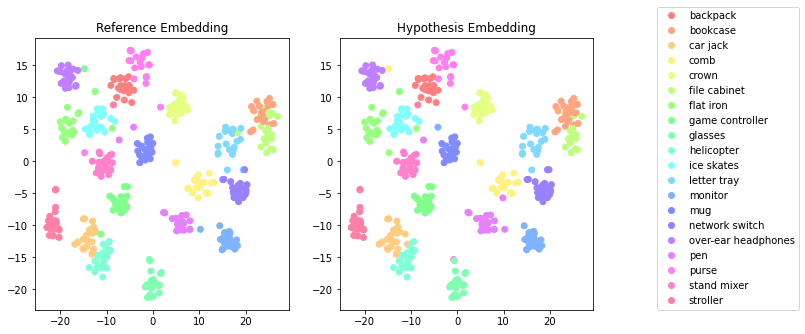

In [63]:
plot_features(e,ref,out,class_mapping,colormap)

### Test Target

Here we test the trained model on the target (product images) test set

In [64]:
# Target results P -> R
cost_function = get_ce_loss()
test_loss, test_accuracy,emb,out = test_step(net, test_loader_r, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [65]:
print(f"Test Loss P -> R: {test_loss}, Test Accuracy P -> R: {test_accuracy}")

Test Loss P -> R: 0.008747350126504898, Test Accuracy P -> R: 78.75


In [66]:
ref = ref_labels(test_loader_r)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


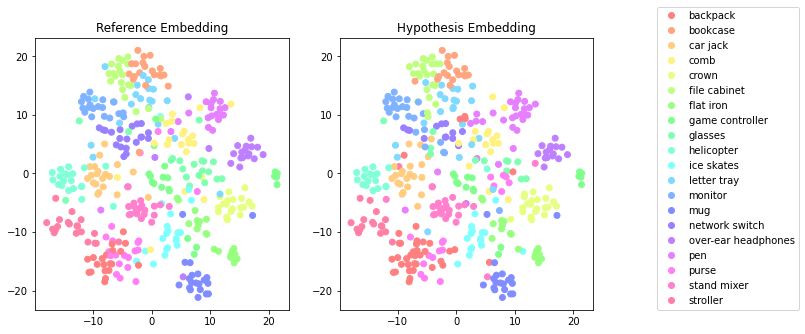

In [67]:
plot_features(e,ref,out,class_mapping,colormap)

#3. MMD + CORAL

Here we test the simple ResNET18 with a simple Domain adaptation strategy based on Correlation Alignment. Two losses of Cross Entropy and CORAL are used

In [49]:
def training_step(net, 
                  source_data_loader, 
                  target_data_loader, 
                  optimizer,
                  ce_cost_fun,coral_cost_fun,mmd_cost_fun,
                  coral_loss_weight,mmd_loss_weight, 
                  device='cuda:0'):
  source_samples = 0.
  target_samples = 0.
  cumulative_ce_loss = 0.
  cumulative_coral_loss = 0.
  cumulative_mmd_loss = 0.
  cumulative_accuracy = 0.
  target_iter = iter(target_data_loader)
  # strictly needed if network contains layers which has different behaviours between train and test
  net.train()
  for batch_idx, (inputs_source, targets) in enumerate(source_data_loader):
    # get target data. If the target iterator reaches the end, restart it
    try:
      inputs_target, _ = next(target_iter)
    except:
      target_iter = iter(target_data_loader)
      inputs_target, _ = next(target_iter)
    inputs = torch.cat((inputs_source, inputs_target), dim=0)
    # loads data inot gpu
    inputs = inputs.to(device)
    targets = targets.to(device)
    # forward pass. I require in out the embeddings of the last layer(8)
    outputs,features = net(inputs,[8])
    features = features[0].squeeze()
    # split the source and target outputs
    source_output, target_output = torch.split(outputs, 
                                               split_size_or_sections=outputs.shape[0] // 2, 
                                               dim=0)
    source_features, target_features = torch.split(features, 
                                            split_size_or_sections=features.shape[0] // 2, 
                                            dim=0)
    # apply the losses
    ce_loss = ce_cost_fun(source_output,targets)
    coral_loss = coral_cost_fun(source_features,target_features)
    mmd_loss =  mmd_cost_fun(source_features,target_features)
    loss = ce_loss + coral_loss_weight * coral_loss+ mmd_loss_weight*mmd_loss
    # backward pass
    loss.backward()
    # update parameters
    optimizer.step()
    # reset the optimizer
    optimizer.zero_grad()
    # print statistics
    source_samples+=inputs_source.shape[0]
    target_samples+=inputs_target.shape[0]
    cumulative_ce_loss += ce_loss.item()
    cumulative_coral_loss += coral_loss.item()
    cumulative_mmd_loss += mmd_loss.item()
    _, predicted = source_output.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_ce_loss/source_samples, cumulative_coral_loss/target_samples,cumulative_mmd_loss/target_samples, cumulative_accuracy/source_samples*100


In [50]:
def train(net,
          source_train_loader,
          source_test_loader,
          target_train_loader,
          target_test_loader,
          optimizer,
          epochs,
          coral_loss_weight=1,
          mmd_loss_weight=1,
          device='cuda:0'):
  writer = SummaryWriter(log_dir="runs/coral")
  # instantiates the cost functions
  ce_cost_function = get_ce_loss()
  coral_cost_function = get_coral_loss()
  mmd_cost_function = get_mmd_loss()
  # range over the number of epochs
  pbar = tqdm(range(epochs),position=0, leave=True)
  for e in pbar:
    ce_train_loss,coral_train_loss,mmd_train_loss, train_accuracy = training_step(net, source_train_loader,target_train_loader,
                                                                 optimizer, 
                                                                 ce_cost_function,coral_cost_function,mmd_cost_function,
                                                                 coral_loss_weight=coral_loss_weight,
                                                                 mmd_loss_weight=mmd_loss_weight,
                                                                 device=device)
    source_test_loss, source_test_accuracy = test_step(net, source_test_loader, ce_cost_function,device=device)
    target_test_loss, target_test_accuracy = test_step(net, target_test_loader, ce_cost_function,device=device)
    pbar.set_description(str({
    'CE Training loss': f'{ce_train_loss:.5f}',
    'CORAL Training loss': f'{coral_train_loss:.5f}',
    'MMD Training loss': f'{mmd_train_loss:.5f}',
    'Training accuracy': f'{train_accuracy:.2f}',    
    'Source Test loss': f'{source_test_loss:.5f}',
    'Source Test accuracy': f'{source_test_accuracy:.2f}',    
    'Target Test loss': f'{target_test_loss:.5f}',
    'Target Test accuracy': f'{target_test_accuracy:.2f}',
    }))
    # add values to logger
    writer.add_scalar('Loss/ce_train_loss', ce_train_loss, e)
    writer.add_scalar('Loss/coral_train_loss', coral_train_loss, e)
    writer.add_scalar('Loss/mmd_train_loss', mmd_train_loss, e)
    writer.add_scalar('Loss/source_test_loss', source_test_loss, e)
    writer.add_scalar('Loss/target_test_loss', target_test_loss, e)
    writer.add_scalar('Accuracy/train_accuracy', train_accuracy, e)
    writer.add_scalar('Accuracy/source_test_accuracy', source_test_accuracy, e)
    writer.add_scalar('Accuracy/target_test_accuracy', target_test_accuracy, e)
  # close the logger
  writer.close()
  return net

## Finetune ResNet18 on R -> P

We train a model of ResNet18 on real life to product 

In [51]:
net = Model(N_CLASSES).to(device)
optimizer = get_optimizer(net,lr=0.001, wd=0.000001, momentum=0.9)
net = train(net,
            source_train_loader=train_loader_r,source_test_loader=test_loader_r,
            target_train_loader=train_loader_p,target_test_loader=test_loader_p, 
         optimizer = optimizer,
         epochs=50, 
         coral_loss_weight=100,
         mmd_loss_weight=100,
         device=device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
{'CE Training loss': '0.00153', 'CORAL Training loss': '0.00005', 'MMD Training loss': '0.00055', 'Training accura

In [52]:
# save
torch.save(net, resnet18_coral_mmd_r_p_path)

In [53]:
!cp $resnet18_coral_mmd_r_p_path "gdrive/MyDrive/"

In [54]:
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 423), started 8:16:55 ago. (Use '!kill 423' to kill it.)

<IPython.core.display.Javascript object>

### Load

we load a pre computed model, useful to avoid retraining the model each time

In [55]:
# load pre trained fine tuned model
net = torch.load(resnet18_coral_mmd_r_p_path)
net.to(device)
net.eval()

Model(
  (Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ReLU(inplace=True)): ReLU(inplace=True)
  (MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d

### Test Source
Here we test the model on the source (real life ) test set

In [56]:
# Source results R
cost_function = get_ce_loss()
test_loss,test_accuracy,emb,out = test_step(net, test_loader_r, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [57]:
print(f"Test Loss R -> R: {test_loss}, Test Accuracy R -> R: {test_accuracy}")

Test Loss R -> R: 0.003796829208731651, Test Accuracy R -> R: 90.5


In [58]:
ref = ref_labels(test_loader_r)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


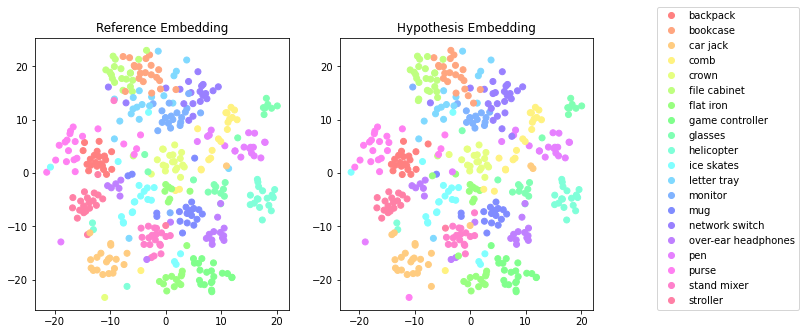

In [59]:
plot_features(e,ref,out,class_mapping,colormap)

### Test Target

Here we test the trained model on the target (product images) test set

In [60]:
# Target results R -> P
cost_function = get_ce_loss()
test_loss, test_accuracy,emb,out = test_step(net, test_loader_p, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [61]:
print(f"Test Loss R -> P: {test_loss}, Test Accuracy R -> P: {test_accuracy}")

Test Loss R -> P: 0.0039001068472862242, Test Accuracy R -> P: 92.5


In [62]:
ref = ref_labels(test_loader_p)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


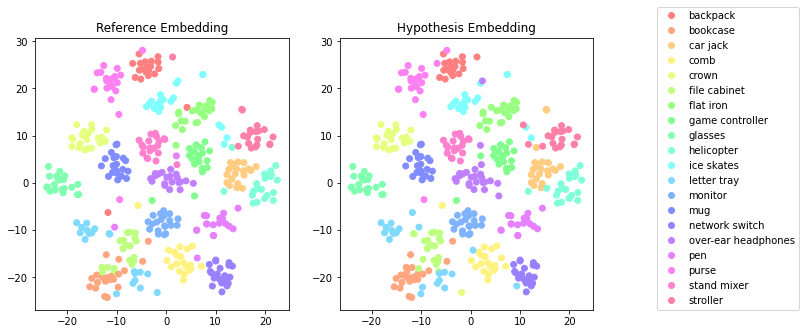

In [63]:
plot_features(e,ref,out,class_mapping,colormap)

## Finetune ResNet18 on P -> R

In [64]:
net = Model(N_CLASSES).to(device)
optimizer = get_optimizer(net,lr=0.001, wd=0.000001, momentum=0.9)
net = train(net,
            source_train_loader=train_loader_p,source_test_loader=test_loader_p,
            target_train_loader=train_loader_r,target_test_loader=test_loader_r, 
         optimizer = optimizer,
         epochs=50, 
         coral_loss_weight=100,
         mmd_loss_weight=100,
         device=device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
{'CE Training loss': '0.00084', 'CORAL Training loss': '0.00004', 'MMD Training loss': '0.00055', 'Training accura

In [65]:
# save
torch.save(net,resnet18_coral_mmd_p_r_path)

In [66]:
!cp $resnet18_coral_mmd_p_r_path "gdrive/MyDrive/"

In [67]:
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 423), started 8:22:16 ago. (Use '!kill 423' to kill it.)

<IPython.core.display.Javascript object>

### Load

we load a pre computed model, useful to avoid retraining the model each time

In [68]:
# load pre trained fine tuned model
net = torch.load(resnet18_coral_mmd_p_r_path)
net.to(device)
net.eval()

Model(
  (Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ReLU(inplace=True)): ReLU(inplace=True)
  (MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d

### Test Source
Here we test the model on the source (real life ) test set

In [69]:
# Source results P
cost_function = get_ce_loss()
test_loss,test_accuracy,emb,out = test_step(net, test_loader_p, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [70]:
print(f"Test Loss P -> P: {test_loss}, Test Accuracy P -> P: {test_accuracy}")

Test Loss P -> P: 0.0021288860589265823, Test Accuracy P -> P: 96.75


In [71]:
ref = ref_labels(test_loader_p)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


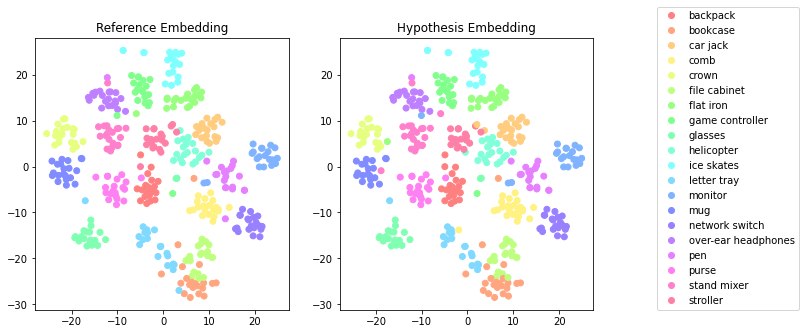

In [72]:
plot_features(e,ref,out,class_mapping,colormap)

### Test Target

Here we test the trained model on the target (product images) test set

In [73]:
# Target results P -> R
cost_function = get_ce_loss()
test_loss, test_accuracy,emb,out = test_step(net, test_loader_r, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [74]:
print(f"Test Loss P -> R: {test_loss}, Test Accuracy P -> R: {test_accuracy}")

Test Loss P -> R: 0.006713418141007423, Test Accuracy P -> R: 80.75


In [75]:
ref = ref_labels(test_loader_r)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


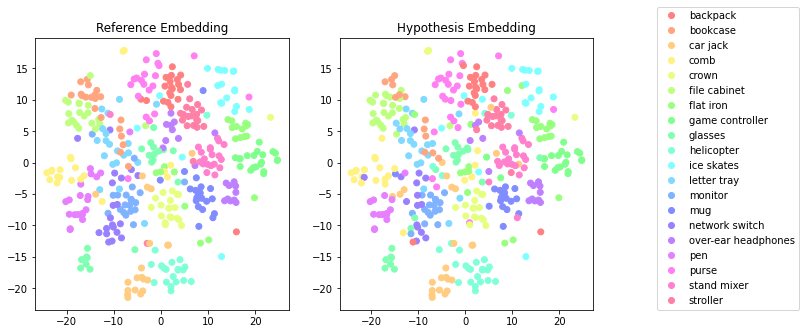

In [76]:
plot_features(e,ref,out,class_mapping,colormap)

# 3. MMD + CORAL + Label Coral

Here we test the simple ResNET18 with a simple Domain adaptation strategy based on Correlation Alignment. Two losses of Cross Entropy and CORAL are used

In [77]:
def training_step(net, 
                  source_data_loader, target_data_loader, 
                  optimizer,
                  ce_cost_fun,coral_cost_fun,label_coral_cost_fun,mmd_cost_fun,
                  label_coral_loss_weight,coral_loss_weight,mmd_loss_weight, 
                  device='cuda:0'):
  source_samples = 0.
  target_samples = 0.
  cumulative_ce_loss = 0.
  cumulative_coral_loss = 0.
  cumulative_label_coral_loss = 0.
  cumulative_mmd_loss = 0.
  cumulative_accuracy = 0.
  target_iter = iter(target_data_loader)
  # strictly needed if network contains layers which has different behaviours between train and test
  net.train()
  for batch_idx, (inputs_source, targets) in enumerate(source_data_loader):
    # get target data. If the target iterator reaches the end, restart it
    try:
      inputs_target, _ = next(target_iter)
    except:
      target_iter = iter(target_data_loader)
      inputs_target, _ = next(target_iter)
    inputs = torch.cat((inputs_source, inputs_target), dim=0)
    # loads data inot gpu
    inputs = inputs.to(device)
    targets = targets.to(device)
    # forward pass. I require in out the embeddings of the last layer(8)
    outputs,features = net(inputs,[8])
    features = features[0].squeeze()
    # split the source and target outputs
    source_output, target_output = torch.split(outputs, 
                                               split_size_or_sections=outputs.shape[0] // 2, 
                                               dim=0)
    source_features, target_features = torch.split(features, 
                                            split_size_or_sections=features.shape[0] // 2, 
                                            dim=0)
    # apply the losses
    ce_loss = ce_cost_fun(source_output,targets)
    coral_loss = coral_cost_fun(source_features,target_features)
    mmd_loss =  mmd_cost_fun(source_features,target_features)
    label_coral_loss = label_coral_cost_fun(source_features,target_features,targets,torch.argmax(target_output,dim=1),net.fc.out_features)
    loss = ce_loss + coral_loss_weight * coral_loss+ mmd_loss_weight*mmd_loss + label_coral_loss_weight*label_coral_loss
    # backward pass
    loss.backward()
    # update parameters
    optimizer.step()
    # reset the optimizer
    optimizer.zero_grad()
    # print statistics
    source_samples+=inputs_source.shape[0]
    target_samples+=inputs_target.shape[0]
    cumulative_ce_loss += ce_loss.item()
    cumulative_coral_loss += coral_loss.item()
    cumulative_label_coral_loss += label_coral_loss
    cumulative_mmd_loss += mmd_loss.item()
    _, predicted = source_output.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_ce_loss/source_samples, cumulative_coral_loss/target_samples,cumulative_label_coral_loss/target_samples,cumulative_mmd_loss/target_samples, cumulative_accuracy/source_samples*100


In [78]:
def train(net,
          source_train_loader,
          source_test_loader,
          target_train_loader,
          target_test_loader,
          optimizer,
          epochs,
          coral_loss_weight=1,
          label_coral_loss_weight=1,
          mmd_loss_weight=1,
          device='cuda:0'):
  writer = SummaryWriter(log_dir="runs/coral")
  # instantiates the cost functions
  ce_cost_function = get_ce_loss()
  coral_cost_function = get_coral_loss()
  label_coral_cost_function = get_label_coral_loss()
  mmd_cost_function = get_mmd_loss()
  # range over the number of epochs
  pbar = tqdm(range(epochs),position=0, leave=True)
  for e in pbar:
    ce_train_loss,coral_train_loss,label_coral_train_loss,mmd_train_loss, train_accuracy = training_step(net, source_train_loader,target_train_loader,
                                                                 optimizer, 
                                                                 ce_cost_function,coral_cost_function,label_coral_cost_function,mmd_cost_function,
                                                                 coral_loss_weight=coral_loss_weight,
                                                                 label_coral_loss_weight=label_coral_loss_weight,
                                                                 mmd_loss_weight=mmd_loss_weight,
                                                                 device=device)
    source_test_loss, source_test_accuracy = test_step(net, source_test_loader, ce_cost_function,device=device)
    target_test_loss, target_test_accuracy = test_step(net, target_test_loader, ce_cost_function,device=device)
    pbar.set_description(str({
    'CE Training loss': f'{ce_train_loss:.5f}',
    'CORAL Training loss': f'{coral_train_loss:.5f}',
    'LABEL CORAL Training loss': f'{label_coral_train_loss:.5f}',
    'MMD Training loss': f'{mmd_train_loss:.5f}',
    'Training accuracy': f'{train_accuracy:.2f}',    
    'Source Test loss': f'{source_test_loss:.5f}',
    'Source Test accuracy': f'{source_test_accuracy:.2f}',    
    'Target Test loss': f'{target_test_loss:.5f}',
    'Target Test accuracy': f'{target_test_accuracy:.2f}',
    }))
    # add values to logger
    writer.add_scalar('Loss/ce_train_loss', ce_train_loss, e)
    writer.add_scalar('Loss/coral_train_loss', coral_train_loss, e)
    writer.add_scalar('Loss/label_coral_train_loss', label_coral_train_loss, e)
    writer.add_scalar('Loss/mmd_train_loss', mmd_train_loss, e)
    writer.add_scalar('Loss/source_test_loss', source_test_loss, e)
    writer.add_scalar('Loss/target_test_loss', target_test_loss, e)
    writer.add_scalar('Accuracy/train_accuracy', train_accuracy, e)
    writer.add_scalar('Accuracy/source_test_accuracy', source_test_accuracy, e)
    writer.add_scalar('Accuracy/target_test_accuracy', target_test_accuracy, e)
  # close the logger
  writer.close()
  return net

## Finetune ResNet18 on R -> P

We train a model of ResNet18 on real life to product 

In [79]:
net = Model(N_CLASSES).to(device)
optimizer = get_optimizer(net,lr=0.001, wd=0.000001, momentum=0.9)
net = train(net,
            source_train_loader=train_loader_r,source_test_loader=test_loader_r,
            target_train_loader=train_loader_p,target_test_loader=test_loader_p, 
         optimizer = optimizer,
         epochs=50, 
         coral_loss_weight=100,
         label_coral_loss_weight=0.25,
         mmd_loss_weight=100,
         device=device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
{'CE Training loss': '0.00164', 'CORAL Training loss': '0.00004', 'LABEL CORAL Training loss': '0.01635', 'MMD Tra

In [80]:
# save
torch.save(net, resnet18_label_coral_mmd_r_p_path)

In [81]:
!cp $resnet18_label_coral_mmd_r_p_path "gdrive/MyDrive/"

In [82]:
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 423), started 8:27:55 ago. (Use '!kill 423' to kill it.)

<IPython.core.display.Javascript object>

### Load

we load a pre computed model, useful to avoid retraining the model each time

In [83]:
# load pre trained fine tuned model
net = torch.load(resnet18_label_coral_mmd_r_p_path)
net.to(device)
net.eval()

Model(
  (Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ReLU(inplace=True)): ReLU(inplace=True)
  (MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d

### Test Source
Here we test the model on the source (real life ) test set

In [84]:
# Source results R
cost_function = get_ce_loss()
test_loss,test_accuracy,emb,out = test_step(net, test_loader_r, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [85]:
print(f"Test Loss R -> R: {test_loss}, Test Accuracy R -> R: {test_accuracy}")

Test Loss R -> R: 0.004113745614886284, Test Accuracy R -> R: 90.25


In [86]:
ref = ref_labels(test_loader_r)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


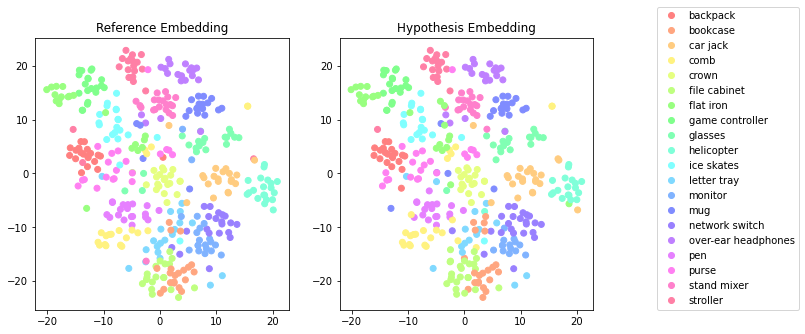

In [87]:
plot_features(e,ref,out,class_mapping,colormap)

### Test Target

Here we test the trained model on the target (product images) test set

In [88]:
# Target results R -> P
cost_function = get_ce_loss()
test_loss, test_accuracy,emb,out = test_step(net, test_loader_p, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [89]:
print(f"Test Loss R -> P: {test_loss}, Test Accuracy R -> P: {test_accuracy}")

Test Loss R -> P: 0.0038482971489429475, Test Accuracy R -> P: 93.0


In [90]:
ref = ref_labels(test_loader_p)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


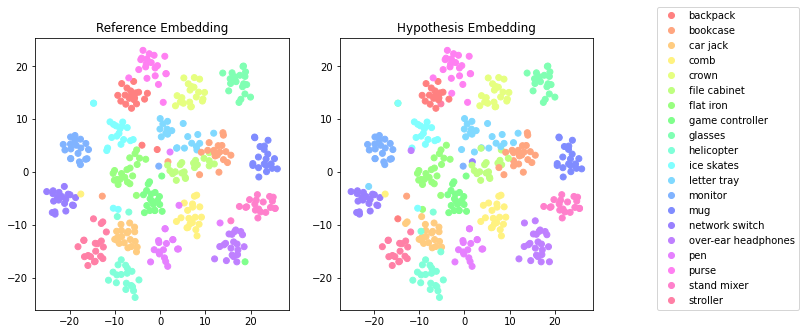

In [91]:
plot_features(e,ref,out,class_mapping,colormap)

## Finetune ResNet18 on P -> R

In [92]:
net = Model(N_CLASSES).to(device)
optimizer = get_optimizer(net,lr=0.001, wd=0.000001, momentum=0.9)
net = train(net,
            source_train_loader=train_loader_p,source_test_loader=test_loader_p,
            target_train_loader=train_loader_r,target_test_loader=test_loader_r, 
         optimizer = optimizer,
         epochs=50, 
         coral_loss_weight=10.0,
         label_coral_loss_weight=0.25,
         mmd_loss_weight=10.0,
         device=device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
{'CE Training loss': '0.00079', 'CORAL Training loss': '0.00005', 'LABEL CORAL Training loss': '0.01981', 'MMD Tra

In [93]:
# save
torch.save(net,resnet18_label_coral_mmd_p_r_path)

In [94]:
!cp $resnet18_label_coral_mmd_p_r_path "gdrive/MyDrive/"

In [95]:
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 423), started 8:33:31 ago. (Use '!kill 423' to kill it.)

<IPython.core.display.Javascript object>

### Load

we load a pre computed model, useful to avoid retraining the model each time

In [96]:
# load pre trained fine tuned model
net = torch.load(resnet18_label_coral_mmd_p_r_path)
net.to(device)
net.eval()

Model(
  (Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ReLU(inplace=True)): ReLU(inplace=True)
  (MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d

### Test Source
Here we test the model on the source (real life ) test set

In [97]:
# Source results P
cost_function = get_ce_loss()
test_loss,test_accuracy,emb,out = test_step(net, test_loader_p, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [98]:
print(f"Test Loss P -> P: {test_loss}, Test Accuracy P -> P: {test_accuracy}")

Test Loss P -> P: 0.002184249646961689, Test Accuracy P -> P: 96.75


In [99]:
ref = ref_labels(test_loader_p)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


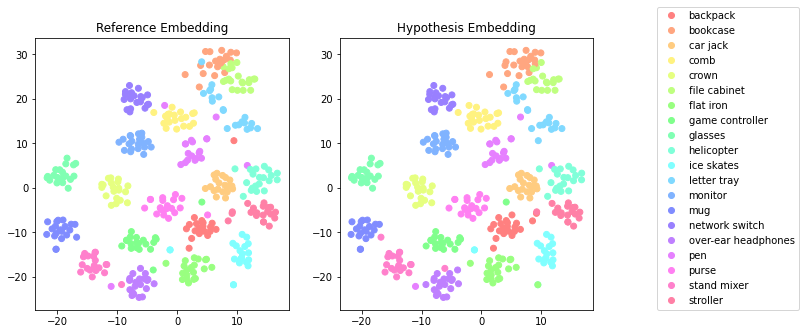

In [100]:
plot_features(e,ref,out,class_mapping,colormap)

### Test Target

Here we test the trained model on the target (product images) test set

In [101]:
# Target results P -> R
cost_function = get_ce_loss()
test_loss, test_accuracy,emb,out = test_step(net, test_loader_r, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [102]:
print(f"Test Loss P -> R: {test_loss}, Test Accuracy P -> R: {test_accuracy}")

Test Loss P -> R: 0.006318228617310524, Test Accuracy P -> R: 82.25


In [103]:
ref = ref_labels(test_loader_r)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


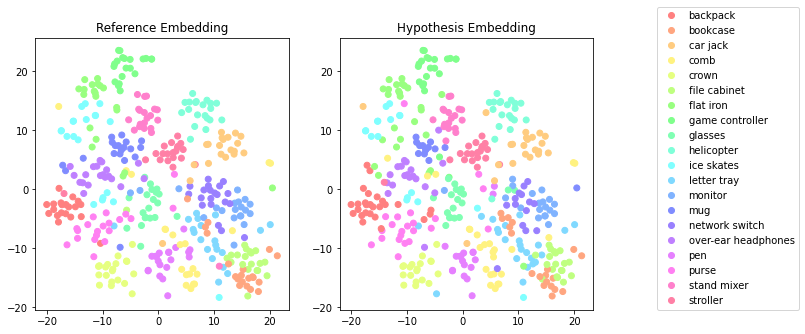

In [104]:
plot_features(e,ref,out,class_mapping,colormap)

# 3. MMD + CORAL + Label Coral + triple

Here we test the simple ResNET18 with a simple Domain adaptation strategy based on Correlation Alignment. Two losses of Cross Entropy and CORAL are used

In [88]:
def training_step(net, 
                  source_data_loader, target_data_loader, 
                  optimizer,
                  ce_cost_fun,coral_cost_fun,label_coral_cost_fun,mmd_cost_fun,trmd_cost_fun,
                  label_coral_loss_weight,coral_loss_weight,mmd_loss_weight,trmd_loss_weight, 
                  device='cuda:0'):
  source_samples = 0.
  target_samples = 0.
  cumulative_ce_loss = 0.
  cumulative_coral_loss = 0.
  cumulative_label_coral_loss = 0.
  cumulative_mmd_loss = 0.
  cumulative_trmd_loss = 0.
  cumulative_accuracy = 0.
  target_iter = iter(target_data_loader)
  # strictly needed if network contains layers which has different behaviours between train and test
  net.train()
  for batch_idx, (inputs_source, targets) in enumerate(source_data_loader):
    # get target data. If the target iterator reaches the end, restart it
    try:
      inputs_target, _ = next(target_iter)
    except:
      target_iter = iter(target_data_loader)
      inputs_target, _ = next(target_iter)
    inputs = torch.cat((inputs_source, inputs_target), dim=0)
    # loads data inot gpu
    inputs = inputs.to(device)
    targets = targets.to(device)
    # forward pass. I require in out the embeddings of the last layer(8)
    outputs,features = net(inputs,[8])
    features = features[0].squeeze()
    # split the source and target outputs
    source_output, target_output = torch.split(outputs, 
                                               split_size_or_sections=outputs.shape[0] // 2, 
                                               dim=0)
    source_features, target_features = torch.split(features, 
                                            split_size_or_sections=features.shape[0] // 2, 
                                            dim=0)
    # apply the losses
    ce_loss = ce_cost_fun(source_output,targets)
    coral_loss = coral_cost_fun(source_features,target_features)
    mmd_loss =  mmd_cost_fun(source_features,target_features)
    label_coral_loss = label_coral_cost_fun(source_features,target_features,targets,torch.argmax(target_output,dim=1),net.fc.out_features)
    trmd_loss = trmd_cost_fun(source_features,target_features,targets,torch.argmax(target_output,dim=1),net.fc.out_features)
    loss = ce_loss + coral_loss_weight * coral_loss+ mmd_loss_weight*mmd_loss + label_coral_loss_weight*label_coral_loss + trmd_loss_weight*trmd_loss
    # backward pass
    loss.backward()
    # update parameters
    optimizer.step()
    # reset the optimizer
    optimizer.zero_grad()
    # print statistics
    source_samples+=inputs_source.shape[0]
    target_samples+=inputs_target.shape[0]
    cumulative_ce_loss += ce_loss.item()
    cumulative_coral_loss += coral_loss.item()
    cumulative_label_coral_loss += label_coral_loss
    cumulative_mmd_loss += mmd_loss.item()
    cumulative_trmd_loss += trmd_loss.item()
    _, predicted = source_output.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_ce_loss/source_samples, cumulative_coral_loss/target_samples,cumulative_label_coral_loss/target_samples,cumulative_mmd_loss/target_samples,cumulative_trmd_loss/target_samples, cumulative_accuracy/source_samples*100


In [86]:
def train(net,
          source_train_loader,
          source_test_loader,
          target_train_loader,
          target_test_loader,
          optimizer,
          epochs,
          coral_loss_weight=1,
          label_coral_loss_weight=1,
          mmd_loss_weight=1,
          trmd_loss_weight=1,
          device='cuda:0'):
  writer = SummaryWriter(log_dir="runs/coral")
  # instantiates the cost functions
  ce_cost_function = get_ce_loss()
  coral_cost_function = get_coral_loss()
  label_coral_cost_function = get_label_coral_loss()
  mmd_cost_function = get_mmd_loss()
  trmd_cost_function = get_trmd_loss()
  # range over the number of epochs
  pbar = tqdm(range(epochs),position=0, leave=True)
  for e in pbar:
    ce_train_loss,coral_train_loss,label_coral_train_loss,mmd_train_loss,trmd_train_loss, train_accuracy = training_step(net, source_train_loader,target_train_loader,
                                                                 optimizer, 
                                                                 ce_cost_function,coral_cost_function,label_coral_cost_function,mmd_cost_function,trmd_cost_function,
                                                                 coral_loss_weight=coral_loss_weight,
                                                                 label_coral_loss_weight=label_coral_loss_weight,
                                                                 mmd_loss_weight=mmd_loss_weight,
                                                                 trmd_loss_weight=trmd_loss_weight,
                                                                 device=device)
    source_test_loss, source_test_accuracy = test_step(net, source_test_loader, ce_cost_function,device=device)
    target_test_loss, target_test_accuracy = test_step(net, target_test_loader, ce_cost_function,device=device)
    pbar.set_description(str({
    'CE Training loss': f'{ce_train_loss:.5f}',
    'CORAL Training loss': f'{coral_train_loss:.5f}',
    'LABEL CORAL Training loss': f'{label_coral_train_loss:.5f}',
    'MMD Training loss': f'{mmd_train_loss:.5f}',
    'TRMD Training loss': f'{trmd_train_loss:.5f}',
    'Training accuracy': f'{train_accuracy:.2f}',    
    'Source Test loss': f'{source_test_loss:.5f}',
    'Source Test accuracy': f'{source_test_accuracy:.2f}',    
    'Target Test loss': f'{target_test_loss:.5f}',
    'Target Test accuracy': f'{target_test_accuracy:.2f}',
    }))
    # add values to logger
    writer.add_scalar('Loss/ce_train_loss', ce_train_loss, e)
    writer.add_scalar('Loss/coral_train_loss', coral_train_loss, e)
    writer.add_scalar('Loss/label_coral_train_loss', label_coral_train_loss, e)
    writer.add_scalar('Loss/mmd_train_loss', mmd_train_loss, e)
    writer.add_scalar('Loss/trmd_train_loss', trmd_train_loss, e)
    writer.add_scalar('Loss/source_test_loss', source_test_loss, e)
    writer.add_scalar('Loss/target_test_loss', target_test_loss, e)
    writer.add_scalar('Accuracy/train_accuracy', train_accuracy, e)
    writer.add_scalar('Accuracy/source_test_accuracy', source_test_accuracy, e)
    writer.add_scalar('Accuracy/target_test_accuracy', target_test_accuracy, e)
  # close the logger
  writer.close()
  return net

## Finetune ResNet18 on R -> P

We train a model of ResNet18 on real life to product 

In [ ]:
net = Model(N_CLASSES).to(device)
optimizer = get_optimizer(net,lr=0.001, wd=0.000001, momentum=0.9)
net = train(net,
            source_train_loader=train_loader_r,source_test_loader=test_loader_r,
            target_train_loader=train_loader_p,target_test_loader=test_loader_p, 
         optimizer = optimizer,
         epochs=50, 
         coral_loss_weight=100,
         label_coral_loss_weight=0.25,
         mmd_loss_weight=100,
         device=device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
{'CE Training loss': '0.00175', 'CORAL Training loss': '0.00005', 'LABEL CORAL Training loss': '0.01435', 'MMD Tra

In [ ]:
# save
torch.save(net, resnet18_label_coral_mmd_trmd_r_p_path)

In [ ]:
!cp $resnet18_label_coral_mmd_trmd_r_p_path "gdrive/MyDrive/"

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

### Load

we load a pre computed model, useful to avoid retraining the model each time

In [ ]:
# load pre trained fine tuned model
net = torch.load(resnet18_label_coral_mmd_trmd_r_p_path)
net.to(device)
net.eval()

### Test Source
Here we test the model on the source (real life ) test set

In [ ]:
# Source results R
cost_function = get_ce_loss()
test_loss,test_accuracy,emb,out = test_step(net, test_loader_r, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [ ]:
print(f"Test Loss R -> R: {test_loss}, Test Accuracy R -> R: {test_accuracy}")

In [ ]:
ref = ref_labels(test_loader_r)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

In [ ]:
plot_features(e,ref,out,class_mapping,colormap)

### Test Target

Here we test the trained model on the target (product images) test set

In [ ]:
# Target results R -> P
cost_function = get_ce_loss()
test_loss, test_accuracy,emb,out = test_step(net, test_loader_p, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [ ]:
print(f"Test Loss R -> P: {test_loss}, Test Accuracy R -> P: {test_accuracy}")

In [ ]:
ref = ref_labels(test_loader_p)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

In [ ]:
plot_features(e,ref,out,class_mapping,colormap)

## Finetune ResNet18 on P -> R

In [91]:
net = Model(N_CLASSES).to(device)
optimizer = get_optimizer(net,lr=0.001, wd=0.000001, momentum=0.9)
net = train(net,
            source_train_loader=train_loader_p,source_test_loader=test_loader_p,
            target_train_loader=train_loader_r,target_test_loader=test_loader_r, 
         optimizer = optimizer,
         epochs=50, 
         coral_loss_weight=10.0,
         label_coral_loss_weight=0.25,
         mmd_loss_weight=10.0,
         trmd_loss_weight=0.25,
         device=device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
{'CE Training loss': '0.00048', 'CORAL Training loss': '0.00007', 'LABEL CORAL Training loss': '0.01826', 'MMD Tra

In [105]:
# save
torch.save(net,resnet18_label_coral_mmd_trmd_p_r_path)

In [106]:
!cp $resnet18_label_coral_mmd_trmd_p_r_path "gdrive/MyDrive/"

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 423), started 8:33:31 ago. (Use '!kill 423' to kill it.)

<IPython.core.display.Javascript object>

### Load

we load a pre computed model, useful to avoid retraining the model each time

In [107]:
# load pre trained fine tuned model
net = torch.load(resnet18_label_coral_mmd_trmd_p_r_path)
net.to(device)
net.eval()

Model(
  (Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ReLU(inplace=True)): ReLU(inplace=True)
  (MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d

### Test Source
Here we test the model on the source (real life ) test set

In [108]:
# Source results P
cost_function = get_ce_loss()
test_loss,test_accuracy,emb,out = test_step(net, test_loader_p, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [109]:
print(f"Test Loss P -> P: {test_loss}, Test Accuracy P -> P: {test_accuracy}")

Test Loss P -> P: 0.0016021201759576797, Test Accuracy P -> P: 96.0


In [110]:
ref = ref_labels(test_loader_p)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


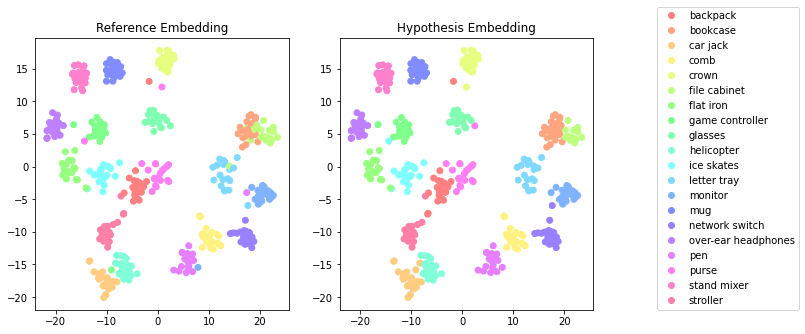

In [111]:
plot_features(e,ref,out,class_mapping,colormap)

### Test Target

Here we test the trained model on the target (product images) test set

In [112]:
# Target results P -> R
cost_function = get_ce_loss()
test_loss, test_accuracy,emb,out = test_step(net, test_loader_r, cost_function,device='cuda:0',features = [8],net_outputs=True)

In [113]:
print(f"Test Loss P -> R: {test_loss}, Test Accuracy P -> R: {test_accuracy}")

Test Loss P -> R: 0.006456325352191925, Test Accuracy P -> R: 83.5


In [114]:
ref = ref_labels(test_loader_r)
out = out.cpu().detach().numpy()
e = emb[0].squeeze().cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


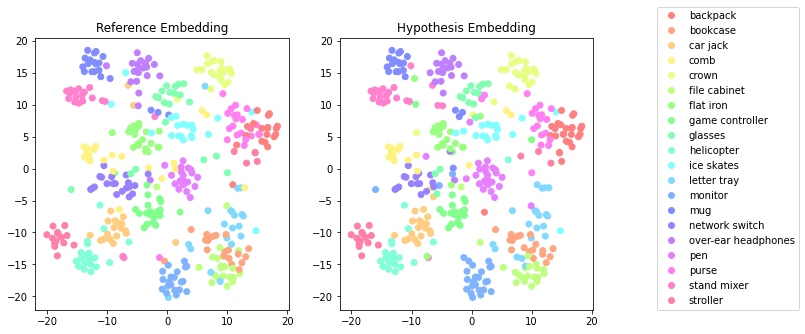

In [115]:
plot_features(e,ref,out,class_mapping,colormap)